# Final Project

In [1]:
import scipy
import scipy.io
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score

from collections import Counter
import matplotlib.pyplot as plt
# import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

### Load Data and Pre-processing

In [2]:
# import and process mRNA
rna = scipy.io.loadmat('mRNA.mat')
mrna = pd.DataFrame(rna['X'])
PID = pd.Series([i[0][0] for i in rna['SampleName']])
mrna["PID"] = PID.str.slice(stop=12)

In [3]:
# import protein data
protein = pd.read_csv('protein.txt', sep='\t')
# drop missing values
protein = protein.dropna(axis= 1)
protein["PID"] = protein['SampleID'].str.slice(stop=12)

In [4]:
# import race information
race = pd.read_csv('race.csv')
race = race[['PID', 'Cancer_type', 'EIGENSTRAT']]
# remove obs with missing race
race = race.dropna()

In [5]:
# merge all data together
protein_race = protein.merge(race, how='inner', on='PID')
mrna_protein_race = mrna.merge(protein_race, how='inner', on='PID')
mrna_protein_race.shape

(7755, 17370)

#### Cancer occurance

We proceed with cancer that has a reasonable number of occurance available for learning in both AA (African American), EA (European) and EAA (Asian). We focus on cancer type BLCA, BRCA, COAD, LIHC, THCA and UCEC. 

In [6]:
# race distribution for the available data
Counter(mrna_protein_race['EIGENSTRAT'])

Counter({'EA': 6531, 'AA': 716, 'EAA': 453, 'OA': 55})

In [7]:
pd.crosstab(mrna_protein_race['Cancer_type'], mrna_protein_race['EIGENSTRAT'])

EIGENSTRAT,AA,EA,EAA,OA
Cancer_type,,,,
ACC,2,40,1,0
BLCA,17,288,39,2
BRCA,141,787,55,9
CESC,15,121,15,0
CHOL,2,33,1,0
COAD,56,325,11,0
DLBC,0,16,15,1
ESCA,2,88,42,1
GBM,6,80,0,2


## Model Training and Evaluation

In [8]:
# shape and standardize data
MRNA = mrna_protein_race.iloc[: , :17176]
protein = mrna_protein_race.iloc[: , 17179:-2]
# standardize both data
scaler = StandardScaler()
MRNA_scale = scaler.fit_transform(MRNA)
protein_scale = scaler.fit_transform(protein)

### Training Task: BLCA

In [9]:
BLCA = 1*np.array(mrna_protein_race['Cancer_type'] == 'BLCA')

Assess mRNA data and select the 200 highly correlated one.


In [10]:
select = SelectKBest(score_func=f_regression, k=200)
BLCA_mrna = select.fit_transform(MRNA_scale,BLCA)
BLCA_X = np.hstack((BLCA_mrna, np.matrix(protein_scale)))

In [11]:
# split train-test data
BLCA_EA_X = BLCA_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'EA'), ]
BLCA_EA_Y = BLCA[np.array(mrna_protein_race['EIGENSTRAT'] == 'EA')]
BLCA_AA_X = BLCA_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'AA'), ]
BLCA_AA_Y = BLCA[np.array(mrna_protein_race['EIGENSTRAT'] == 'AA')]
BLCA_EAA_X = BLCA_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'EAA'), ]
BLCA_EAA_Y = BLCA[np.array(mrna_protein_race['EIGENSTRAT'] == 'EAA')]

BLCA_X_train_EA, BLCA_X_test_EA, BLCA_Y_train_EA, BLCA_Y_test_EA = train_test_split(BLCA_EA_X, BLCA_EA_Y, stratify=BLCA_EA_Y, test_size=0.2, random_state=42)
BLCA_X_train_AA, BLCA_X_test_AA, BLCA_Y_train_AA, BLCA_Y_test_AA = train_test_split(BLCA_AA_X, BLCA_AA_Y, stratify=BLCA_AA_Y, test_size=0.5, random_state=42)
BLCA_X_train_EAA, BLCA_X_test_EAA, BLCA_Y_train_EAA, BLCA_Y_test_EAA = train_test_split(BLCA_EAA_X, BLCA_EAA_Y, stratify=BLCA_EAA_Y, test_size=0.5, random_state=42)

#### Basic setup

In [12]:
batch_size = 20
epoches = 100

class DNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(389, 128),
        nn.Dropout(p = 0.5),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.Dropout(p = 0.5),
        nn.ReLU(),
        nn.Linear(64, 2))

  def forward(self, x):
    x = self.layers(x)
    return x

Loss = torch.nn.CrossEntropyLoss()

In [13]:
def train(net, train_loader, test_loader, epoch):
    train_loss_history = []
    test_loss_history = []
    test_precision_history = []
    test_recall_history = []
    test_auc_history = []
    
    for epoch in range(epoch):
        train_loss = 0.0
        test_loss = 0.0
        
        # train
        for i, data in enumerate(train_loader):
                X, y = data
                optimizer.zero_grad()
                predicted_output = net(X)
                fit = Loss(predicted_output,y)
                predicted = predicted_output.argmax(dim=1)
                fit.backward()
                optimizer.step()
                train_loss += fit.item()
        train_loss_history.append(train_loss/len(train_loader))
        
        # test 
        for i, data in enumerate(test_loader):
            with torch.no_grad():
                X, y = data
                predicted_output = net(X)
                fit = Loss(predicted_output,y)
                test_loss_history.append(fit.item())
                predicted = predicted_output.argmax(dim=1)
                test_precision_history.append(precision_score(y, predicted))
                test_recall_history.append(recall_score(y, predicted))
                test_auc_history.append(roc_auc_score(y, predicted))
        
    return train_loss_history,test_loss_history, test_precision_history, test_recall_history, test_auc_history

### Independent training

Independent training is where each race group just use its own data to train the model.

In [14]:
# Race EA
EA_net = DNN()
optimizer = torch.optim.SGD(EA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BLCA_X_train_EA)), torch.from_numpy(BLCA_Y_train_EA))
BLCA_EA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BLCA_X_test_EA)), torch.from_numpy(BLCA_Y_test_EA))
BLCA_EA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(BLCA_Y_test_EA), shuffle=True)

BLCA_EA_train_loss, BLCA_EA_test_loss, BLCA_EA_precison, BLCA_EA_recall, BLCA_EA_AUC = train(EA_net, BLCA_EA_train_loader, BLCA_EA_test_loader, 100)

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# Race AA
AA_net = DNN()
optimizer = torch.optim.SGD(AA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BLCA_X_train_AA)), torch.from_numpy(BLCA_Y_train_AA))
BLCA_AA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BLCA_X_test_AA)), torch.from_numpy(BLCA_Y_test_AA))
BLCA_AA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(BLCA_Y_test_AA), shuffle=True)

BLCA_AA_train_loss, BLCA_AA_test_loss, BLCA_AA_precison, BLCA_AA_recall, BLCA_AA_AUC = train(AA_net, BLCA_AA_train_loader, BLCA_AA_test_loader, 100)

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classifica

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classifica

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# Race EAA
EAA_net = DNN()
optimizer = torch.optim.SGD(EAA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BLCA_X_train_EAA)), torch.from_numpy(BLCA_Y_train_EAA))
BLCA_EAA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BLCA_X_test_EAA)), torch.from_numpy(BLCA_Y_test_EAA))
BLCA_EAA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(BLCA_Y_test_EAA), shuffle=True)

BLCA_EAA_train_loss, BLCA_EAA_test_loss, BLCA_EAA_precison, BLCA_EAA_recall, BLCA_EAA_AUC = train(EAA_net, BLCA_EAA_train_loader, BLCA_EAA_test_loader, 100)

### Fine-Tune algorithm 1

For fine-tune algorithm 1, the model is first trained by the source group (EA group). The model is then fine-tuned using data from target groups, using a smaller training rate.

In [17]:
# AA
AA_net1 = EA_net
optimizer = torch.optim.SGD(AA_net1.parameters(), lr=0.002)
# new batch size
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BLCA_X_train_AA)), torch.from_numpy(BLCA_Y_train_AA))
BLCA_AA_train_loader1 = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
# tune
BLCA_AA_train_loss1, BLCA_AA_test_loss1, BLCA_AA_precison1, BLCA_AA_recall1, BLCA_AA_AUC1 = train(AA_net1, BLCA_AA_train_loader1, BLCA_AA_test_loader, 100)

In [18]:
# EAA
EAA_net1 = EA_net
optimizer = torch.optim.SGD(EAA_net1.parameters(), lr=0.002)
# new batch size
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BLCA_X_train_EAA)), torch.from_numpy(BLCA_Y_train_EAA))
BLCA_EAA_train_loader1 = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
# tune
BLCA_EAA_train_loss1, BLCA_EAA_test_loss1, BLCA_EAA_precison1, BLCA_EAA_recall1, BLCA_EAA_AUC1 = train(EAA_net1, BLCA_EAA_train_loader1, BLCA_AA_test_loader, 100)

### Fine-Tune algorithm 2

For fine-tune algorithm 2, we first trained an stacked denoising autoencoder using data from all race groups. Then the trained encoder is combined with an output layer for classification, such that all models has the same structure.

In [26]:
# define encoder
class encoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(389, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU())

  def forward(self, x):
    x = self.layers(x)
    return x   

# define decoder
class decoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 389),
        nn.Sigmoid())

  def forward(self, x):
    x = self.layers(x)
    return x  

In [27]:
# function for encoder training. Fixed epoch = 200
def encoder_train(encoder, decoder, dataloader):
    train_loss_history = []
    for epoch in range(200):
        train_loss = 0.0
        for i, data in enumerate(dataloader):
            X, y = data
            optimizer.zero_grad()
            predicted_output = encoder(X)
            predicted_output = decoder(predicted_output)
            fit = criterion(predicted_output,X)
            fit.backward()
            optimizer.step()
            train_loss += fit.item()
            
        train_loss_history.append(train_loss/len(dataloader))
    # plot train loss
    plt.plot(np.arange(1, 201), train_loss_history)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show     

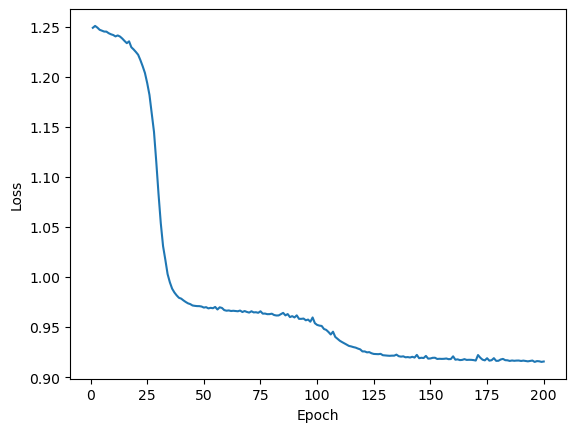

In [28]:
# train auto encoder using all available data
encoder1 = encoder()
decoder1 = decoder()
criterion=nn.MSELoss()
params_to_optimize = [{'params': encoder1.parameters()}, {'params': decoder1.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.01,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BLCA_X)), torch.from_numpy(BLCA))
BLCA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)

# train autoencoder
encoder_train(encoder1, decoder1, BLCA_train_loader)

In [29]:
# fine tune network
class finetune(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(64, 2))

  def forward(self, x):
    x = self.layers(x)
    return x

In [30]:
# finetune training
def ft_train(net, net1, train_loader, test_loader, epoch):
    train_loss_history = []
    test_loss_history = []
    test_precision_history = []
    test_recall_history = []
    test_auc_history = []
    
    for epoch in range(epoch):
        train_loss = 0.0
        test_loss = 0.0
        
        # train
        for i, data in enumerate(train_loader):
                X, y = data
                optimizer.zero_grad()
                predicted_output = net(X)
                predicted_output = net1(predicted_output)
                fit = Loss(predicted_output,y)
                predicted = predicted_output.argmax(dim=1)
                fit.backward()
                optimizer.step()
                train_loss += fit.item()
        train_loss_history.append(train_loss/len(train_loader))
        
        # test 
        for i, data in enumerate(test_loader):
            with torch.no_grad():
                X, y = data
                predicted_output = net(X)
                predicted_output = net1(predicted_output)
                fit = Loss(predicted_output,y)
                test_loss_history.append(fit.item())
                predicted = predicted_output.argmax(dim=1)
                test_precision_history.append(precision_score(y, predicted))
                test_recall_history.append(recall_score(y, predicted))
                test_auc_history.append(roc_auc_score(y, predicted))
        
    return train_loss_history,test_loss_history, test_precision_history, test_recall_history, test_auc_history

In [32]:
# EA
encoder_EA = encoder1
finetune_EA = finetune()
params_to_optimize = [{'params': encoder_EA.parameters()}, {'params': finetune_EA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BLCA_X_train_EA)), torch.from_numpy(BLCA_Y_train_EA))
BLCA_EA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
BLCA_EA_train_loss2, BLCA_EA_test_loss2, BLCA_EA_precison2, BLCA_EA_recall2, BLCA_EA_AUC2 = ft_train(encoder_EA, finetune_EA, BLCA_EA_train_loader, BLCA_EA_test_loader, 100)

In [33]:
# AA
encoder_AA = encoder1
finetune_AA = finetune()
params_to_optimize = [{'params': encoder_AA.parameters()}, {'params': finetune_AA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BLCA_X_train_AA)), torch.from_numpy(BLCA_Y_train_AA))
BLCA_AA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
BLCA_AA_train_loss2, BLCA_AA_test_loss2, BLCA_AA_precison2, BLCA_AA_recall2, BLCA_AA_AUC2 = ft_train(encoder_AA, finetune_AA, BLCA_AA_train_loader, BLCA_AA_test_loader, 100)

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
# EAA
encoder_EAA = encoder1
finetune_EAA = finetune()
params_to_optimize = [{'params': encoder_EAA.parameters()}, {'params': finetune_EAA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BLCA_X_train_EAA)), torch.from_numpy(BLCA_Y_train_EAA))
BLCA_EAA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
BLCA_EAA_train_loss2, BLCA_EAA_test_loss2, BLCA_EAA_precison2, BLCA_EAA_recall2, BLCA_EAA_AUC2 = ft_train(encoder_EAA, finetune_EAA, BLCA_EAA_train_loader, BLCA_EAA_test_loader, 100)


### Summary Plots

#### Train-test loss

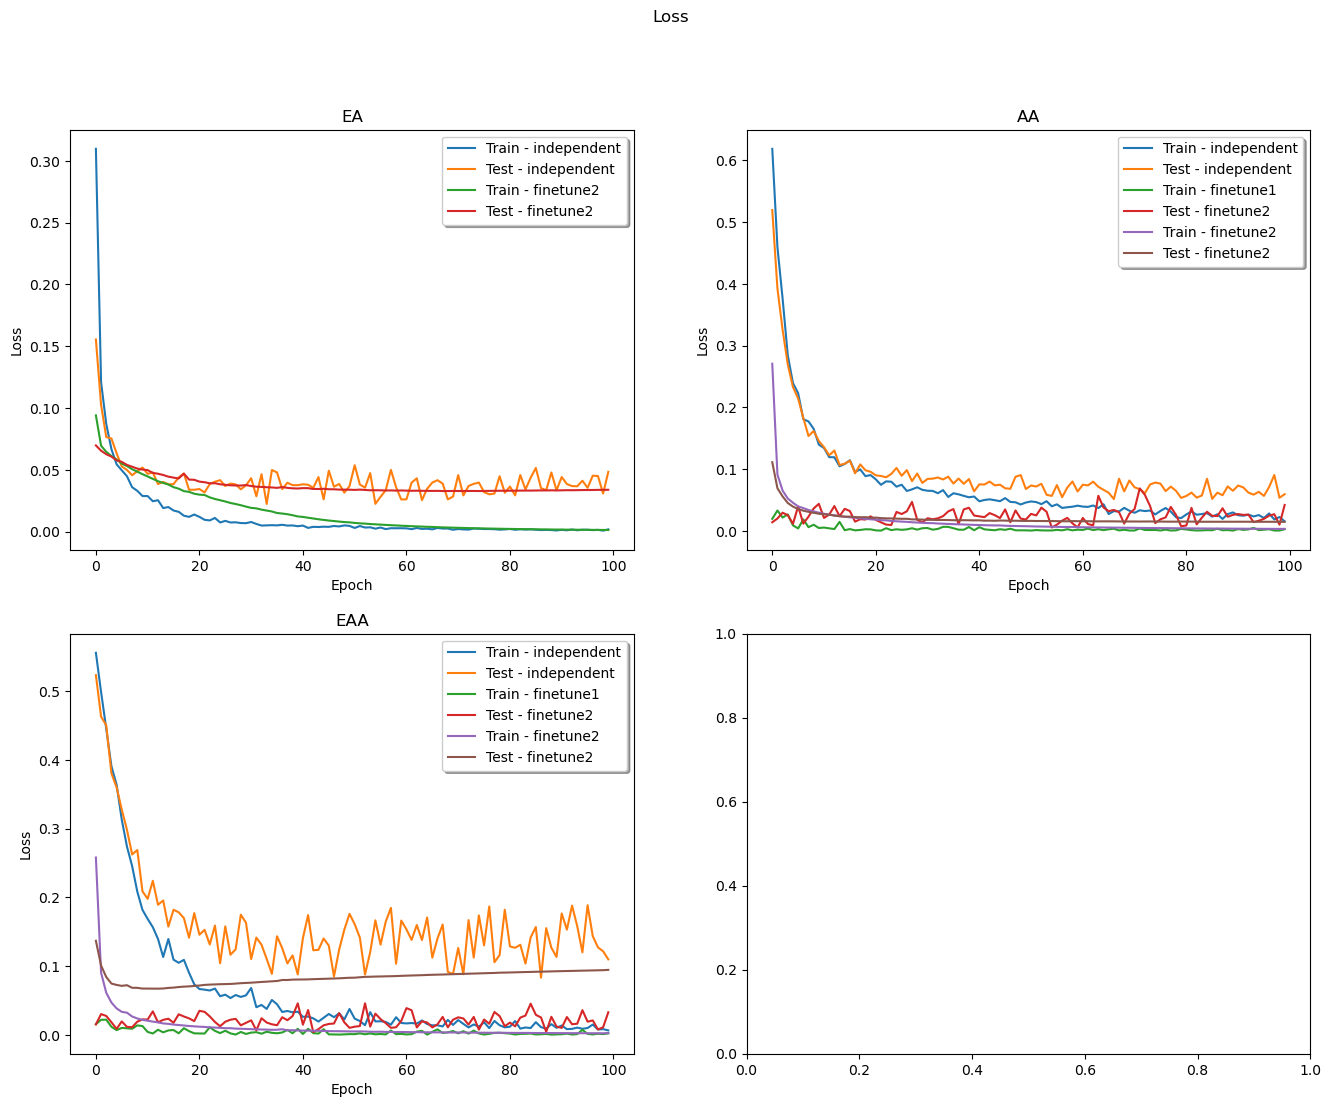

In [46]:
figure, axis = plt.subplots(2, 2, figsize = (16,12))
figure.suptitle('Loss')

# EA
axis[0, 0].plot(range(100), BLCA_EA_train_loss, label = "Train - independent")
axis[0, 0].plot(range(100), BLCA_EA_test_loss, label = "Test - independent")
axis[0, 0].plot(range(100), BLCA_EA_train_loss2, label = "Train - finetune2")
axis[0, 0].plot(range(100), BLCA_EA_test_loss2, label = "Test - finetune2")
axis[0, 0].set_title('EA')
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("Loss")
axis[0, 0].legend(shadow=True)


# AA
axis[0, 1].plot(range(100), BLCA_AA_train_loss, label = "Train - independent")
axis[0, 1].plot(range(100), BLCA_AA_test_loss, label = "Test - independent")
axis[0, 1].plot(range(100), BLCA_AA_train_loss1, label = "Train - finetune1")
axis[0, 1].plot(range(100), BLCA_AA_test_loss1, label = "Test - finetune2")
axis[0, 1].plot(range(100), BLCA_AA_train_loss2, label = "Train - finetune2")
axis[0, 1].plot(range(100), BLCA_AA_test_loss2, label = "Test - finetune2")
axis[0, 1].set_title('AA')
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("Loss")
axis[0, 1].legend(shadow=True)

  
# Test Recall
axis[1, 0].plot(range(100), BLCA_EAA_train_loss, label = "Train - independent")
axis[1, 0].plot(range(100), BLCA_EAA_test_loss, label = "Test - independent")
axis[1, 0].plot(range(100), BLCA_EAA_train_loss1, label = "Train - finetune1")
axis[1, 0].plot(range(100), BLCA_EAA_test_loss1, label = "Test - finetune2")
axis[1, 0].plot(range(100), BLCA_EAA_train_loss2, label = "Train - finetune2")
axis[1, 0].plot(range(100), BLCA_EAA_test_loss2, label = "Test - finetune2")
axis[1, 0].set_title('EAA')
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("Loss")
axis[1, 0].legend(shadow=True)

  
# Combine all the operations and display
plt.show()

#### Model Metrix

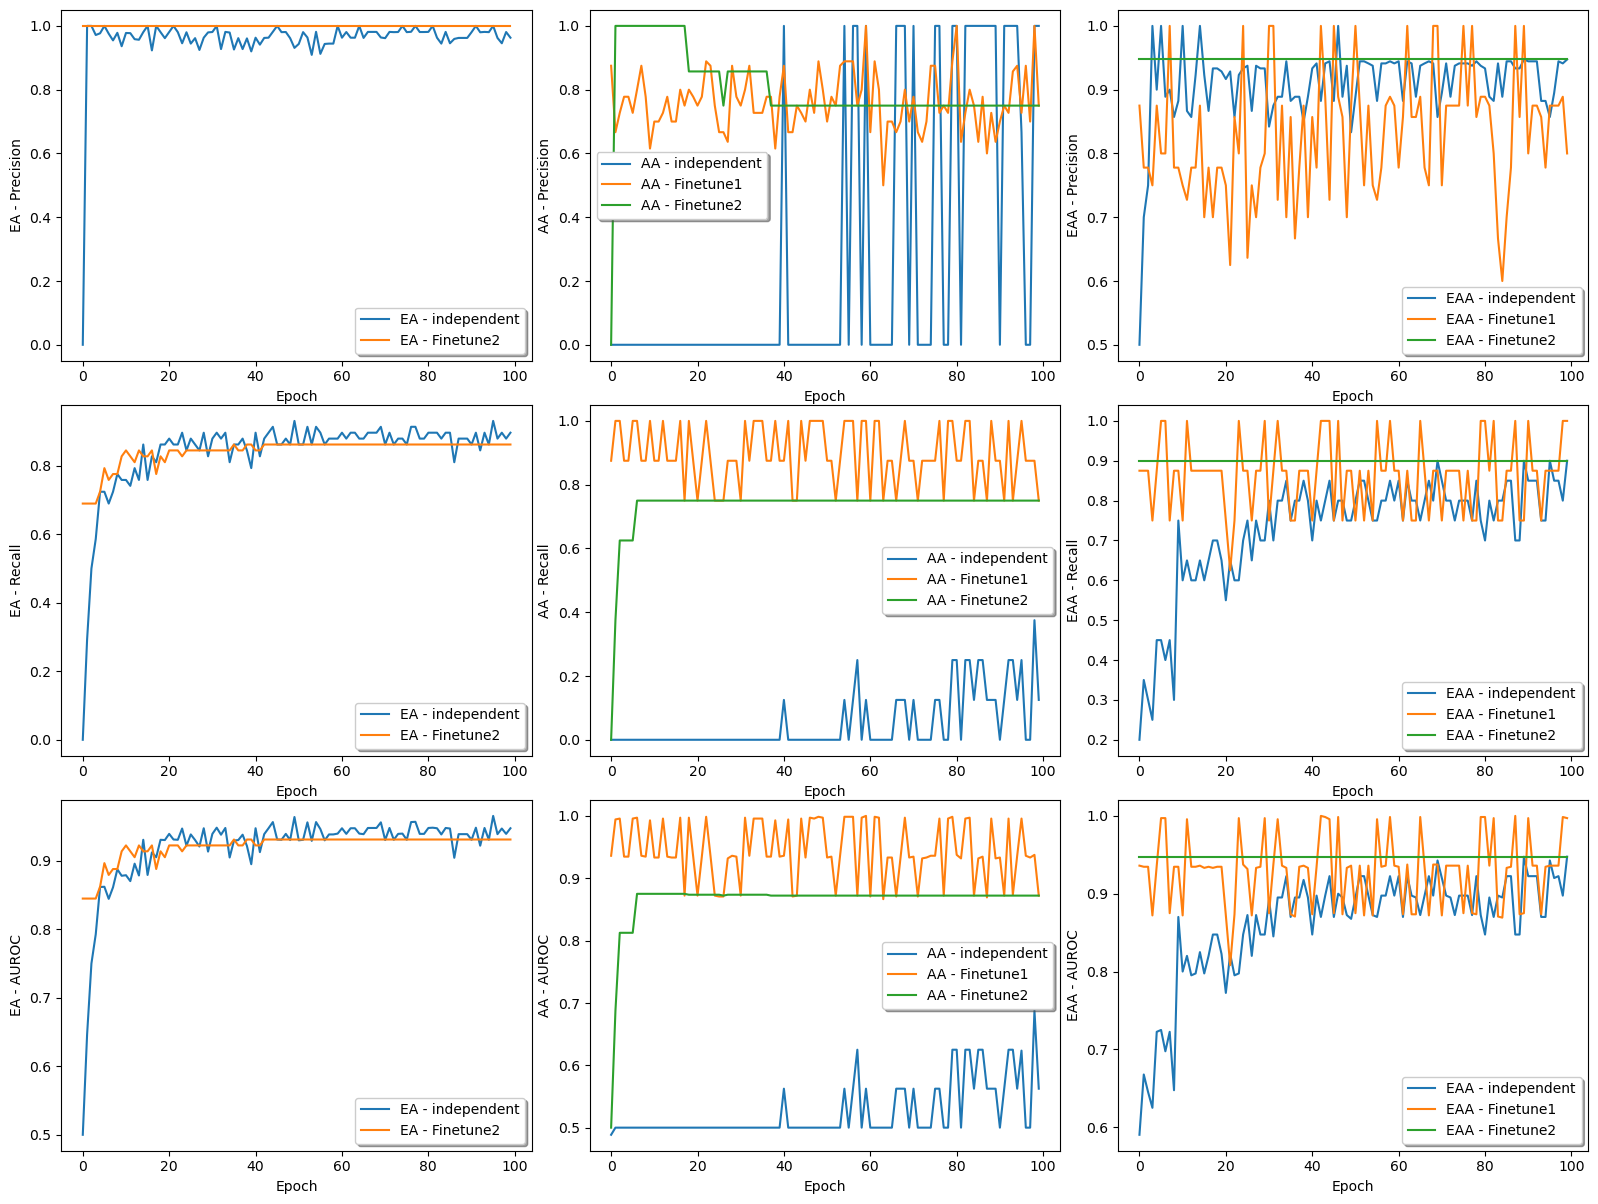

In [55]:
figure, axis = plt.subplots(3, 3, figsize = (16,12))
figure.tight_layout()

# Precision
axis[0, 0].plot(range(100), BLCA_EA_precison, label = "EA - independent")
axis[0, 0].plot(range(100), BLCA_EA_precison2, label = "EA - Finetune2")
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("EA - Precision")
axis[0, 0].legend(shadow=True)


axis[0, 1].plot(range(100), BLCA_AA_precison, label = "AA - independent")
axis[0, 1].plot(range(100), BLCA_AA_precison1, label = "AA - Finetune1")
axis[0, 1].plot(range(100), BLCA_AA_precison2, label = "AA - Finetune2")
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("AA - Precision")
axis[0, 1].legend(shadow=True)


axis[0, 2].plot(range(100), BLCA_EAA_precison, label = "EAA - independent")
axis[0, 2].plot(range(100), BLCA_EAA_precison1, label = "EAA - Finetune1")
axis[0, 2].plot(range(100), BLCA_EAA_precison2, label = "EAA - Finetune2")
axis[0, 2].set_xlabel("Epoch")
axis[0, 2].set_ylabel("EAA - Precision")
axis[0, 2].legend(shadow=True)


# Recall
axis[1, 0].plot(range(100), BLCA_EA_recall, label = "EA - independent")
axis[1, 0].plot(range(100), BLCA_EA_recall2, label = "EA - Finetune2")
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("EA - Recall")
axis[1, 0].legend(shadow=True)


axis[1, 1].plot(range(100), BLCA_AA_recall, label = "AA - independent")
axis[1, 1].plot(range(100), BLCA_AA_recall1, label = "AA - Finetune1")
axis[1, 1].plot(range(100), BLCA_AA_recall2, label = "AA - Finetune2")
axis[1, 1].set_xlabel("Epoch")
axis[1, 1].set_ylabel("AA - Recall")
axis[1, 1].legend(shadow=True)


axis[1, 2].plot(range(100), BLCA_EAA_recall, label = "EAA - independent")
axis[1, 2].plot(range(100), BLCA_EAA_recall1, label = "EAA - Finetune1")
axis[1, 2].plot(range(100), BLCA_EAA_recall2, label = "EAA - Finetune2")
axis[1, 2].set_xlabel("Epoch")
axis[1, 2].set_ylabel("EAA - Recall")
axis[1, 2].legend(shadow=True)

  
# Test Recall
axis[2, 0].plot(range(100), BLCA_EA_AUC, label = "EA - independent")
axis[2, 0].plot(range(100), BLCA_EA_AUC2, label = "EA - Finetune2")
axis[2, 0].set_xlabel("Epoch")
axis[2, 0].set_ylabel("EA - AUROC")
axis[2, 0].legend(shadow=True)

axis[2, 1].plot(range(100), BLCA_AA_AUC, label = "AA - independent")
axis[2, 1].plot(range(100), BLCA_AA_AUC1, label = "AA - Finetune1")
axis[2, 1].plot(range(100), BLCA_AA_AUC2, label = "AA - Finetune2")
axis[2, 1].set_xlabel("Epoch")
axis[2, 1].set_ylabel("AA - AUROC")
axis[2, 1].legend(shadow=True)

axis[2, 2].plot(range(100), BLCA_EAA_AUC, label = "EAA - independent")
axis[2, 2].plot(range(100), BLCA_EAA_AUC1, label = "EAA - Finetune1")
axis[2, 2].plot(range(100), BLCA_EAA_AUC2, label = "EAA - Finetune2")
axis[2, 2].set_xlabel("Epoch")
axis[2, 2].set_ylabel("EAA - AUROC")
axis[2, 2].legend(shadow=True)


### Training Task: BRCA

In [56]:
BRCA = 1*np.array(mrna_protein_race['Cancer_type'] == 'BRCA')

select = SelectKBest(score_func=f_regression, k=200)
BRCA_mrna = select.fit_transform(MRNA_scale,BRCA)
BRCA_X = np.hstack((BRCA_mrna, np.matrix(protein_scale)))

# split train-test data
BRCA_EA_X = BRCA_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'EA'), ]
BRCA_EA_Y = BRCA[np.array(mrna_protein_race['EIGENSTRAT'] == 'EA')]
BRCA_AA_X = BRCA_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'AA'), ]
BRCA_AA_Y = BRCA[np.array(mrna_protein_race['EIGENSTRAT'] == 'AA')]
BRCA_EAA_X = BRCA_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'EAA'), ]
BRCA_EAA_Y = BRCA[np.array(mrna_protein_race['EIGENSTRAT'] == 'EAA')]

BRCA_X_train_EA, BRCA_X_test_EA, BRCA_Y_train_EA, BRCA_Y_test_EA = train_test_split(BRCA_EA_X, BRCA_EA_Y, stratify=BRCA_EA_Y, test_size=0.2, random_state=42)
BRCA_X_train_AA, BRCA_X_test_AA, BRCA_Y_train_AA, BRCA_Y_test_AA = train_test_split(BRCA_AA_X, BRCA_AA_Y, stratify=BRCA_AA_Y, test_size=0.5, random_state=42)
BRCA_X_train_EAA, BRCA_X_test_EAA, BRCA_Y_train_EAA, BRCA_Y_test_EAA = train_test_split(BRCA_EAA_X, BRCA_EAA_Y, stratify=BRCA_EAA_Y, test_size=0.5, random_state=42)


#### Independent

In [57]:
# Race EA
EA_net = DNN()
optimizer = torch.optim.SGD(EA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BRCA_X_train_EA)), torch.from_numpy(BRCA_Y_train_EA))
BRCA_EA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BRCA_X_test_EA)), torch.from_numpy(BRCA_Y_test_EA))
BRCA_EA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(BRCA_Y_test_EA), shuffle=True)

BRCA_EA_train_loss, BRCA_EA_test_loss, BRCA_EA_precison, BRCA_EA_recall, BRCA_EA_AUC = train(EA_net, BRCA_EA_train_loader, BRCA_EA_test_loader, 100)



# Race AA
AA_net = DNN()
optimizer = torch.optim.SGD(AA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BRCA_X_train_AA)), torch.from_numpy(BRCA_Y_train_AA))
BRCA_AA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BRCA_X_test_AA)), torch.from_numpy(BRCA_Y_test_AA))
BRCA_AA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(BRCA_Y_test_AA), shuffle=True)

BRCA_AA_train_loss, BRCA_AA_test_loss, BRCA_AA_precison, BRCA_AA_recall, BRCA_AA_AUC = train(AA_net, BRCA_AA_train_loader, BRCA_AA_test_loader, 100)



# Race EAA
EAA_net = DNN()
optimizer = torch.optim.SGD(EAA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BRCA_X_train_EAA)), torch.from_numpy(BRCA_Y_train_EAA))
BRCA_EAA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BRCA_X_test_EAA)), torch.from_numpy(BRCA_Y_test_EAA))
BRCA_EAA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(BRCA_Y_test_EAA), shuffle=True)

BRCA_EAA_train_loss, BRCA_EAA_test_loss, BRCA_EAA_precison, BRCA_EAA_recall, BRCA_EAA_AUC = train(EAA_net, BRCA_EAA_train_loader, BRCA_EAA_test_loader, 100)


#### Fine-tune 1

In [58]:
# AA
AA_net1 = EA_net
optimizer = torch.optim.SGD(AA_net1.parameters(), lr=0.002)
# new batch size
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BRCA_X_train_AA)), torch.from_numpy(BRCA_Y_train_AA))
BRCA_AA_train_loader1 = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
# tune
BRCA_AA_train_loss1, BRCA_AA_test_loss1, BRCA_AA_precison1, BRCA_AA_recall1, BRCA_AA_AUC1 = train(AA_net1, BRCA_AA_train_loader1, BRCA_AA_test_loader, 100)

# EAA
EAA_net1 = EA_net
optimizer = torch.optim.SGD(EAA_net1.parameters(), lr=0.002)
# new batch size
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BRCA_X_train_EAA)), torch.from_numpy(BRCA_Y_train_EAA))
BRCA_EAA_train_loader1 = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
# tune
BRCA_EAA_train_loss1, BRCA_EAA_test_loss1, BRCA_EAA_precison1, BRCA_EAA_recall1, BRCA_EAA_AUC1 = train(EAA_net1, BRCA_EAA_train_loader1, BRCA_AA_test_loader, 100)


#### Fine-tune 2

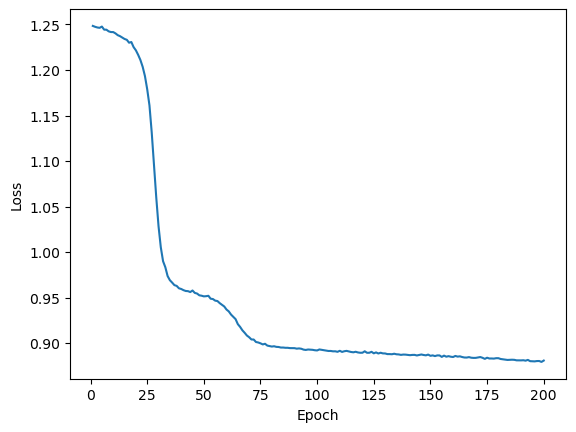

In [59]:
# train auto encoder using all available data
encoder1 = encoder()
decoder1 = decoder()
criterion=nn.MSELoss()
params_to_optimize = [{'params': encoder1.parameters()}, {'params': decoder1.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.01,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BRCA_X)), torch.from_numpy(BRCA))
BRCA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)

# train autoencoder
encoder_train(encoder1, decoder1, BRCA_train_loader)

# EA
encoder_EA = encoder1
finetune_EA = finetune()
params_to_optimize = [{'params': encoder_EA.parameters()}, {'params': finetune_EA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BRCA_X_train_EA)), torch.from_numpy(BRCA_Y_train_EA))
BRCA_EA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
BRCA_EA_train_loss2, BRCA_EA_test_loss2, BRCA_EA_precison2, BRCA_EA_recall2, BRCA_EA_AUC2 = ft_train(encoder_EA, finetune_EA, BRCA_EA_train_loader, BRCA_EA_test_loader, 100)

# AA
encoder_AA = encoder1
finetune_AA = finetune()
params_to_optimize = [{'params': encoder_AA.parameters()}, {'params': finetune_AA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BRCA_X_train_AA)), torch.from_numpy(BRCA_Y_train_AA))
BRCA_AA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
BRCA_AA_train_loss2, BRCA_AA_test_loss2, BRCA_AA_precison2, BRCA_AA_recall2, BRCA_AA_AUC2 = ft_train(encoder_AA, finetune_AA, BRCA_AA_train_loader, BRCA_AA_test_loader, 100)


# EAA
encoder_EAA = encoder1
finetune_EAA = finetune()
params_to_optimize = [{'params': encoder_EAA.parameters()}, {'params': finetune_EAA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(BRCA_X_train_EAA)), torch.from_numpy(BRCA_Y_train_EAA))
BRCA_EAA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
BRCA_EAA_train_loss2, BRCA_EAA_test_loss2, BRCA_EAA_precison2, BRCA_EAA_recall2, BRCA_EAA_AUC2 = ft_train(encoder_EAA, finetune_EAA, BRCA_EAA_train_loader, BRCA_EAA_test_loader, 100)


#### Plots

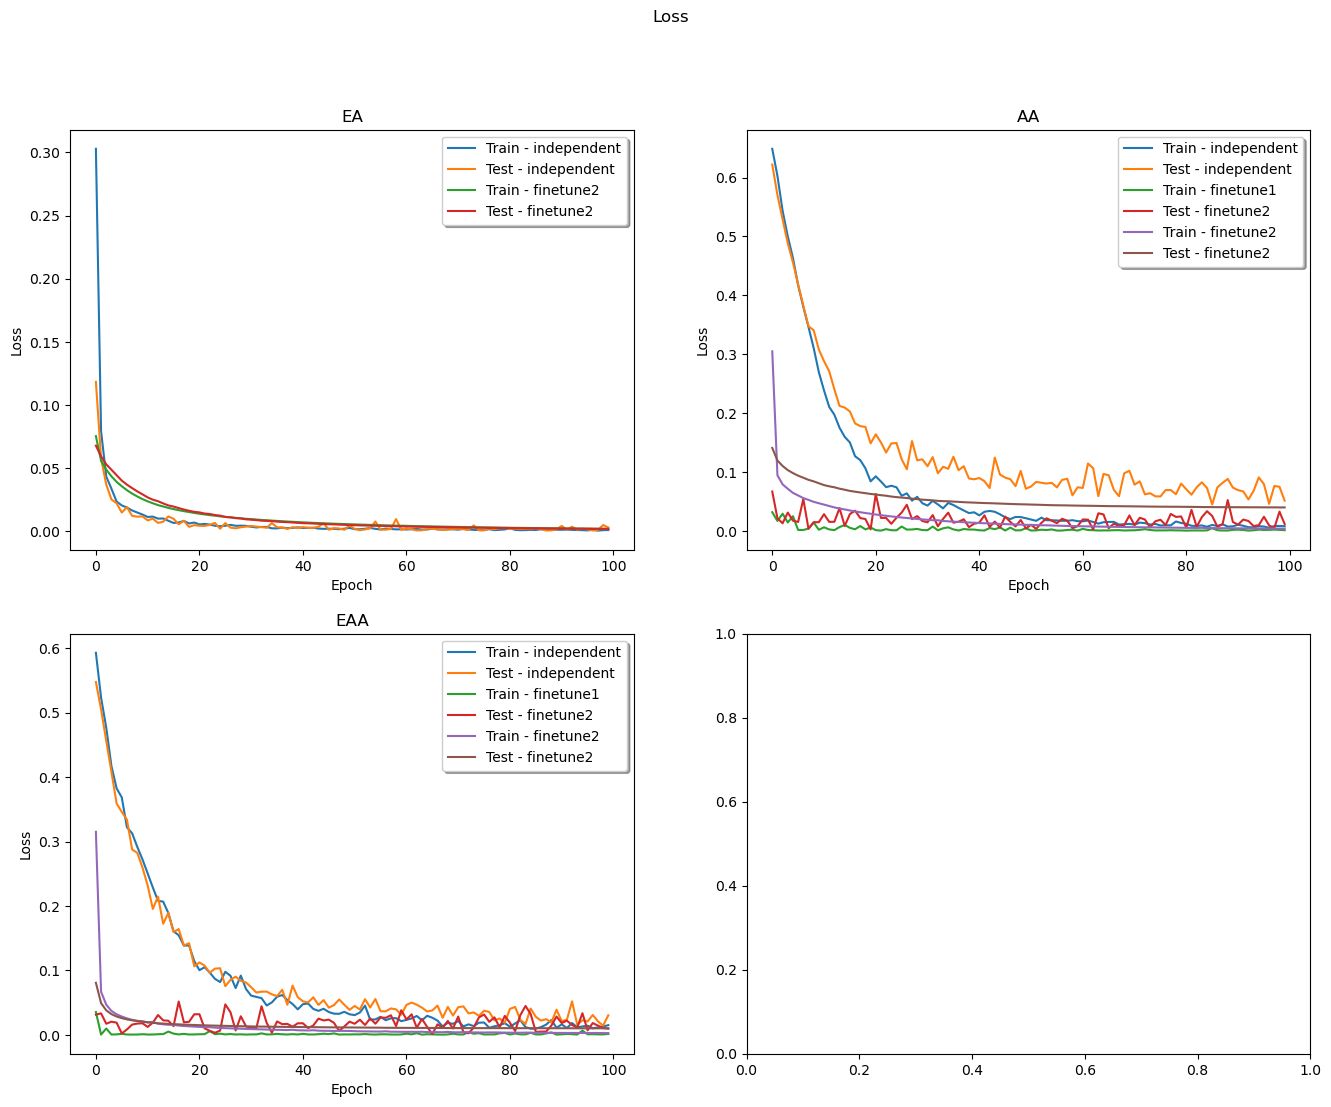

In [60]:
figure, axis = plt.subplots(2, 2, figsize = (16,12))
figure.suptitle('Loss')

# EA
axis[0, 0].plot(range(100), BRCA_EA_train_loss, label = "Train - independent")
axis[0, 0].plot(range(100), BRCA_EA_test_loss, label = "Test - independent")
axis[0, 0].plot(range(100), BRCA_EA_train_loss2, label = "Train - finetune2")
axis[0, 0].plot(range(100), BRCA_EA_test_loss2, label = "Test - finetune2")
axis[0, 0].set_title('EA')
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("Loss")
axis[0, 0].legend(shadow=True)


# AA
axis[0, 1].plot(range(100), BRCA_AA_train_loss, label = "Train - independent")
axis[0, 1].plot(range(100), BRCA_AA_test_loss, label = "Test - independent")
axis[0, 1].plot(range(100), BRCA_AA_train_loss1, label = "Train - finetune1")
axis[0, 1].plot(range(100), BRCA_AA_test_loss1, label = "Test - finetune2")
axis[0, 1].plot(range(100), BRCA_AA_train_loss2, label = "Train - finetune2")
axis[0, 1].plot(range(100), BRCA_AA_test_loss2, label = "Test - finetune2")
axis[0, 1].set_title('AA')
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("Loss")
axis[0, 1].legend(shadow=True)

  
# Test Recall
axis[1, 0].plot(range(100), BRCA_EAA_train_loss, label = "Train - independent")
axis[1, 0].plot(range(100), BRCA_EAA_test_loss, label = "Test - independent")
axis[1, 0].plot(range(100), BRCA_EAA_train_loss1, label = "Train - finetune1")
axis[1, 0].plot(range(100), BRCA_EAA_test_loss1, label = "Test - finetune2")
axis[1, 0].plot(range(100), BRCA_EAA_train_loss2, label = "Train - finetune2")
axis[1, 0].plot(range(100), BRCA_EAA_test_loss2, label = "Test - finetune2")
axis[1, 0].set_title('EAA')
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("Loss")
axis[1, 0].legend(shadow=True)

  
# Combine all the operations and display
plt.show()


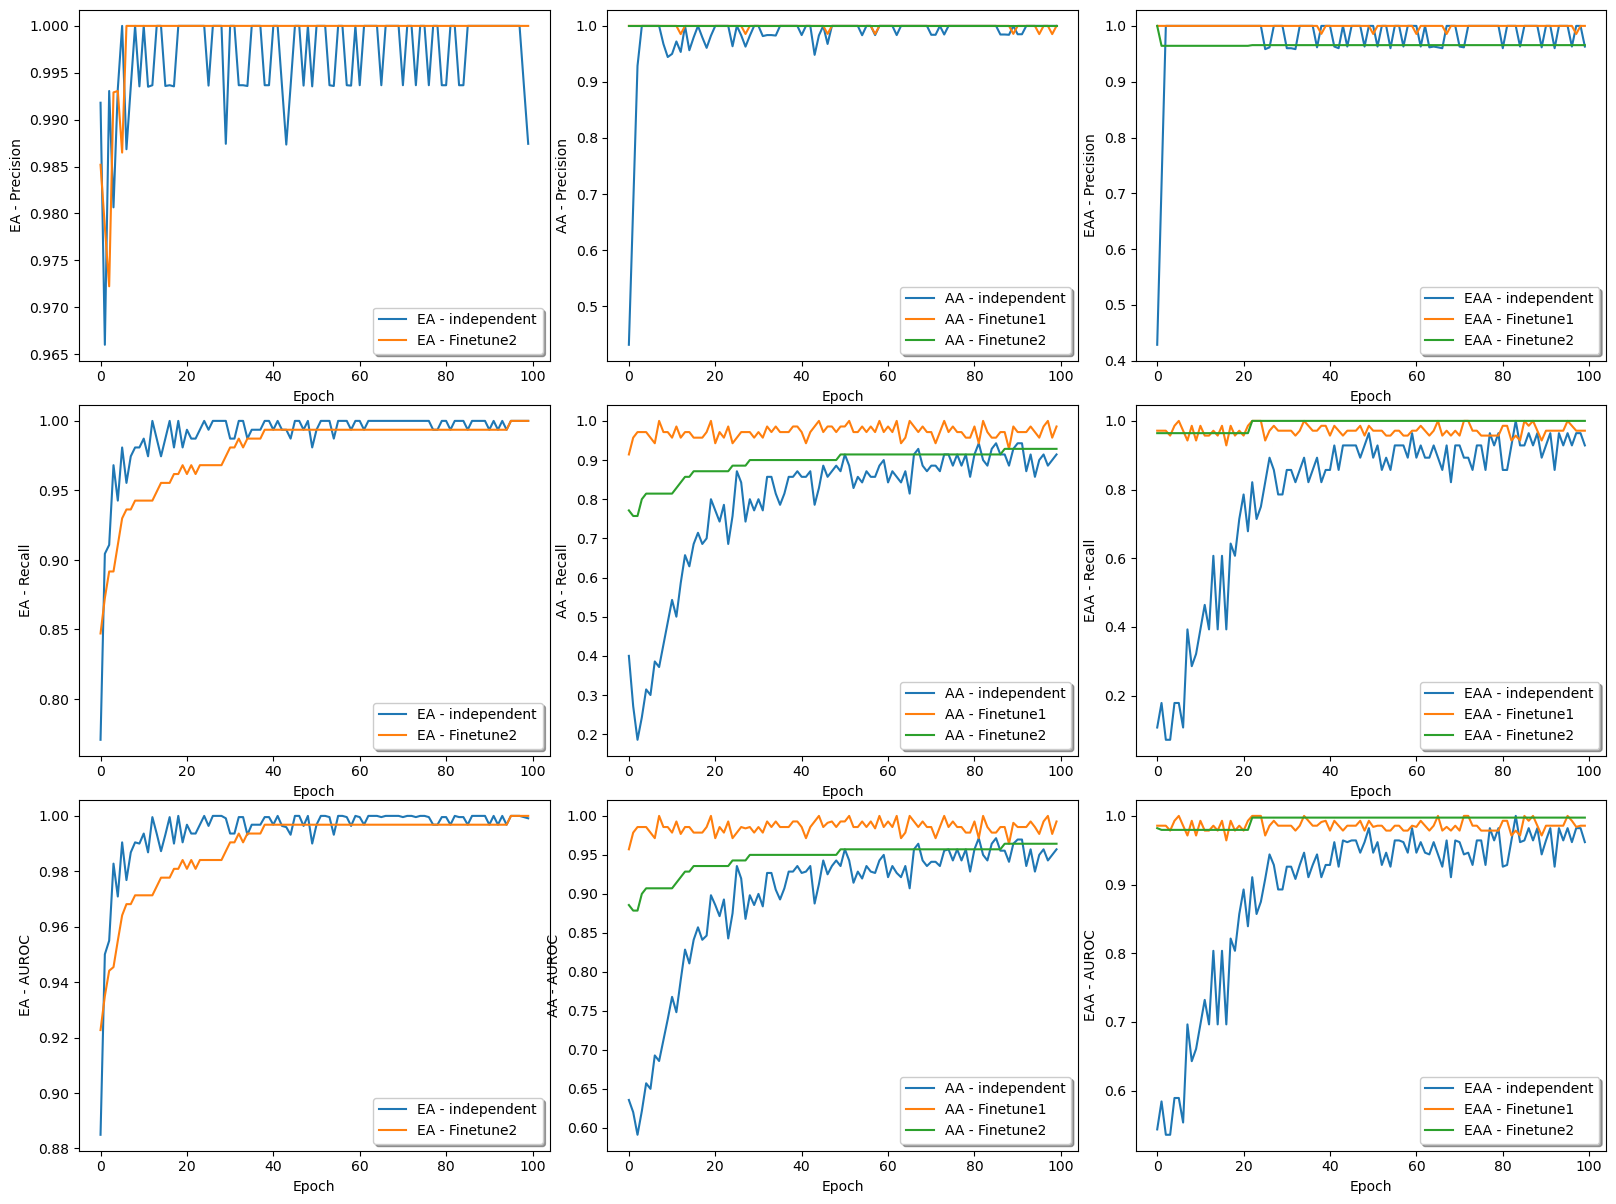

In [61]:
figure, axis = plt.subplots(3, 3, figsize = (16,12))
figure.tight_layout()

# Precision
axis[0, 0].plot(range(100), BRCA_EA_precison, label = "EA - independent")
axis[0, 0].plot(range(100), BRCA_EA_precison2, label = "EA - Finetune2")
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("EA - Precision")
axis[0, 0].legend(shadow=True)


axis[0, 1].plot(range(100), BRCA_AA_precison, label = "AA - independent")
axis[0, 1].plot(range(100), BRCA_AA_precison1, label = "AA - Finetune1")
axis[0, 1].plot(range(100), BRCA_AA_precison2, label = "AA - Finetune2")
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("AA - Precision")
axis[0, 1].legend(shadow=True)


axis[0, 2].plot(range(100), BRCA_EAA_precison, label = "EAA - independent")
axis[0, 2].plot(range(100), BRCA_EAA_precison1, label = "EAA - Finetune1")
axis[0, 2].plot(range(100), BRCA_EAA_precison2, label = "EAA - Finetune2")
axis[0, 2].set_xlabel("Epoch")
axis[0, 2].set_ylabel("EAA - Precision")
axis[0, 2].legend(shadow=True)


# Recall
axis[1, 0].plot(range(100), BRCA_EA_recall, label = "EA - independent")
axis[1, 0].plot(range(100), BRCA_EA_recall2, label = "EA - Finetune2")
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("EA - Recall")
axis[1, 0].legend(shadow=True)


axis[1, 1].plot(range(100), BRCA_AA_recall, label = "AA - independent")
axis[1, 1].plot(range(100), BRCA_AA_recall1, label = "AA - Finetune1")
axis[1, 1].plot(range(100), BRCA_AA_recall2, label = "AA - Finetune2")
axis[1, 1].set_xlabel("Epoch")
axis[1, 1].set_ylabel("AA - Recall")
axis[1, 1].legend(shadow=True)


axis[1, 2].plot(range(100), BRCA_EAA_recall, label = "EAA - independent")
axis[1, 2].plot(range(100), BRCA_EAA_recall1, label = "EAA - Finetune1")
axis[1, 2].plot(range(100), BRCA_EAA_recall2, label = "EAA - Finetune2")
axis[1, 2].set_xlabel("Epoch")
axis[1, 2].set_ylabel("EAA - Recall")
axis[1, 2].legend(shadow=True)

  
# Test Recall
axis[2, 0].plot(range(100), BRCA_EA_AUC, label = "EA - independent")
axis[2, 0].plot(range(100), BRCA_EA_AUC2, label = "EA - Finetune2")
axis[2, 0].set_xlabel("Epoch")
axis[2, 0].set_ylabel("EA - AUROC")
axis[2, 0].legend(shadow=True)

axis[2, 1].plot(range(100), BRCA_AA_AUC, label = "AA - independent")
axis[2, 1].plot(range(100), BRCA_AA_AUC1, label = "AA - Finetune1")
axis[2, 1].plot(range(100), BRCA_AA_AUC2, label = "AA - Finetune2")
axis[2, 1].set_xlabel("Epoch")
axis[2, 1].set_ylabel("AA - AUROC")
axis[2, 1].legend(shadow=True)

axis[2, 2].plot(range(100), BRCA_EAA_AUC, label = "EAA - independent")
axis[2, 2].plot(range(100), BRCA_EAA_AUC1, label = "EAA - Finetune1")
axis[2, 2].plot(range(100), BRCA_EAA_AUC2, label = "EAA - Finetune2")
axis[2, 2].set_xlabel("Epoch")
axis[2, 2].set_ylabel("EAA - AUROC")
axis[2, 2].legend(shadow=True)


### Training Task: COAD

In [62]:
COAD = 1*np.array(mrna_protein_race['Cancer_type'] == 'COAD')

select = SelectKBest(score_func=f_regression, k=200)
COAD_mrna = select.fit_transform(MRNA_scale,COAD)
COAD_X = np.hstack((COAD_mrna, np.matrix(protein_scale)))

# split train-test data
COAD_EA_X = COAD_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'EA'), ]
COAD_EA_Y = COAD[np.array(mrna_protein_race['EIGENSTRAT'] == 'EA')]
COAD_AA_X = COAD_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'AA'), ]
COAD_AA_Y = COAD[np.array(mrna_protein_race['EIGENSTRAT'] == 'AA')]
COAD_EAA_X = COAD_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'EAA'), ]
COAD_EAA_Y = COAD[np.array(mrna_protein_race['EIGENSTRAT'] == 'EAA')]

COAD_X_train_EA, COAD_X_test_EA, COAD_Y_train_EA, COAD_Y_test_EA = train_test_split(COAD_EA_X, COAD_EA_Y, stratify=COAD_EA_Y, test_size=0.2, random_state=42)
COAD_X_train_AA, COAD_X_test_AA, COAD_Y_train_AA, COAD_Y_test_AA = train_test_split(COAD_AA_X, COAD_AA_Y, stratify=COAD_AA_Y, test_size=0.5, random_state=42)
COAD_X_train_EAA, COAD_X_test_EAA, COAD_Y_train_EAA, COAD_Y_test_EAA = train_test_split(COAD_EAA_X, COAD_EAA_Y, stratify=COAD_EAA_Y, test_size=0.5, random_state=42)

#### Independent

In [63]:
# Race EA
EA_net = DNN()
optimizer = torch.optim.SGD(EA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(COAD_X_train_EA)), torch.from_numpy(COAD_Y_train_EA))
COAD_EA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(COAD_X_test_EA)), torch.from_numpy(COAD_Y_test_EA))
COAD_EA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(COAD_Y_test_EA), shuffle=True)

COAD_EA_train_loss, COAD_EA_test_loss, COAD_EA_precison, COAD_EA_recall, COAD_EA_AUC = train(EA_net, COAD_EA_train_loader, COAD_EA_test_loader, 100)

# Race AA
AA_net = DNN()
optimizer = torch.optim.SGD(AA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(COAD_X_train_AA)), torch.from_numpy(COAD_Y_train_AA))
COAD_AA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(COAD_X_test_AA)), torch.from_numpy(COAD_Y_test_AA))
COAD_AA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(COAD_Y_test_AA), shuffle=True)

COAD_AA_train_loss, COAD_AA_test_loss, COAD_AA_precison, COAD_AA_recall, COAD_AA_AUC = train(AA_net, COAD_AA_train_loader, COAD_AA_test_loader, 100)

# Race EAA
EAA_net = DNN()
optimizer = torch.optim.SGD(EAA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(COAD_X_train_EAA)), torch.from_numpy(COAD_Y_train_EAA))
COAD_EAA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(COAD_X_test_EAA)), torch.from_numpy(COAD_Y_test_EAA))
COAD_EAA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(COAD_Y_test_EAA), shuffle=True)

COAD_EAA_train_loss, COAD_EAA_test_loss, COAD_EAA_precison, COAD_EAA_recall, COAD_EAA_AUC = train(EAA_net, COAD_EAA_train_loader, COAD_EAA_test_loader, 100)


/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classifica

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classifica

#### Fine-tune 1

In [64]:
# AA
AA_net1 = EA_net
optimizer = torch.optim.SGD(AA_net1.parameters(), lr=0.002)
# new batch size
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(COAD_X_train_AA)), torch.from_numpy(COAD_Y_train_AA))
COAD_AA_train_loader1 = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
# tune
COAD_AA_train_loss1, COAD_AA_test_loss1, COAD_AA_precison1, COAD_AA_recall1, COAD_AA_AUC1 = train(AA_net1, COAD_AA_train_loader1, COAD_AA_test_loader, 100)

# EAA
EAA_net1 = EA_net
optimizer = torch.optim.SGD(EAA_net1.parameters(), lr=0.002)
# new batch size
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(COAD_X_train_EAA)), torch.from_numpy(COAD_Y_train_EAA))
COAD_EAA_train_loader1 = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
# tune
COAD_EAA_train_loss1, COAD_EAA_test_loss1, COAD_EAA_precison1, COAD_EAA_recall1, COAD_EAA_AUC1 = train(EAA_net1, COAD_EAA_train_loader1, COAD_AA_test_loader, 100)


#### Fine-tune 2

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classifica

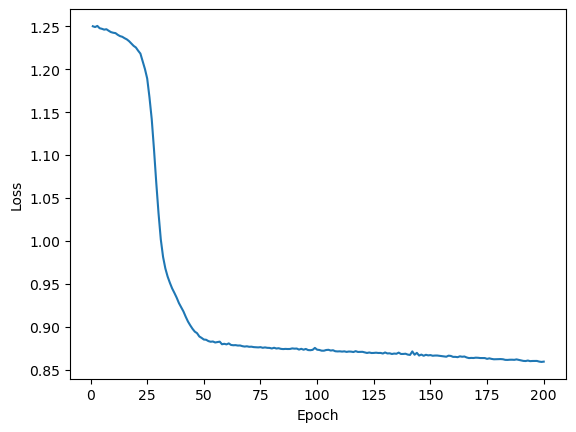

In [65]:
# train auto encoder using all available data
encoder1 = encoder()
decoder1 = decoder()
criterion=nn.MSELoss()
params_to_optimize = [{'params': encoder1.parameters()}, {'params': decoder1.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.01,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(COAD_X)), torch.from_numpy(COAD))
COAD_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)

# train autoencoder
encoder_train(encoder1, decoder1, COAD_train_loader)

# EA
encoder_EA = encoder1
finetune_EA = finetune()
params_to_optimize = [{'params': encoder_EA.parameters()}, {'params': finetune_EA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(COAD_X_train_EA)), torch.from_numpy(COAD_Y_train_EA))
COAD_EA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
COAD_EA_train_loss2, COAD_EA_test_loss2, COAD_EA_precison2, COAD_EA_recall2, COAD_EA_AUC2 = ft_train(encoder_EA, finetune_EA, COAD_EA_train_loader, COAD_EA_test_loader, 100)

# AA
encoder_AA = encoder1
finetune_AA = finetune()
params_to_optimize = [{'params': encoder_AA.parameters()}, {'params': finetune_AA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(COAD_X_train_AA)), torch.from_numpy(COAD_Y_train_AA))
COAD_AA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
COAD_AA_train_loss2, COAD_AA_test_loss2, COAD_AA_precison2, COAD_AA_recall2, COAD_AA_AUC2 = ft_train(encoder_AA, finetune_AA, COAD_AA_train_loader, COAD_AA_test_loader, 100)


# EAA
encoder_EAA = encoder1
finetune_EAA = finetune()
params_to_optimize = [{'params': encoder_EAA.parameters()}, {'params': finetune_EAA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(COAD_X_train_EAA)), torch.from_numpy(COAD_Y_train_EAA))
COAD_EAA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
COAD_EAA_train_loss2, COAD_EAA_test_loss2, COAD_EAA_precison2, COAD_EAA_recall2, COAD_EAA_AUC2 = ft_train(encoder_EAA, finetune_EAA, COAD_EAA_train_loader, COAD_EAA_test_loader, 100)


#### Plots

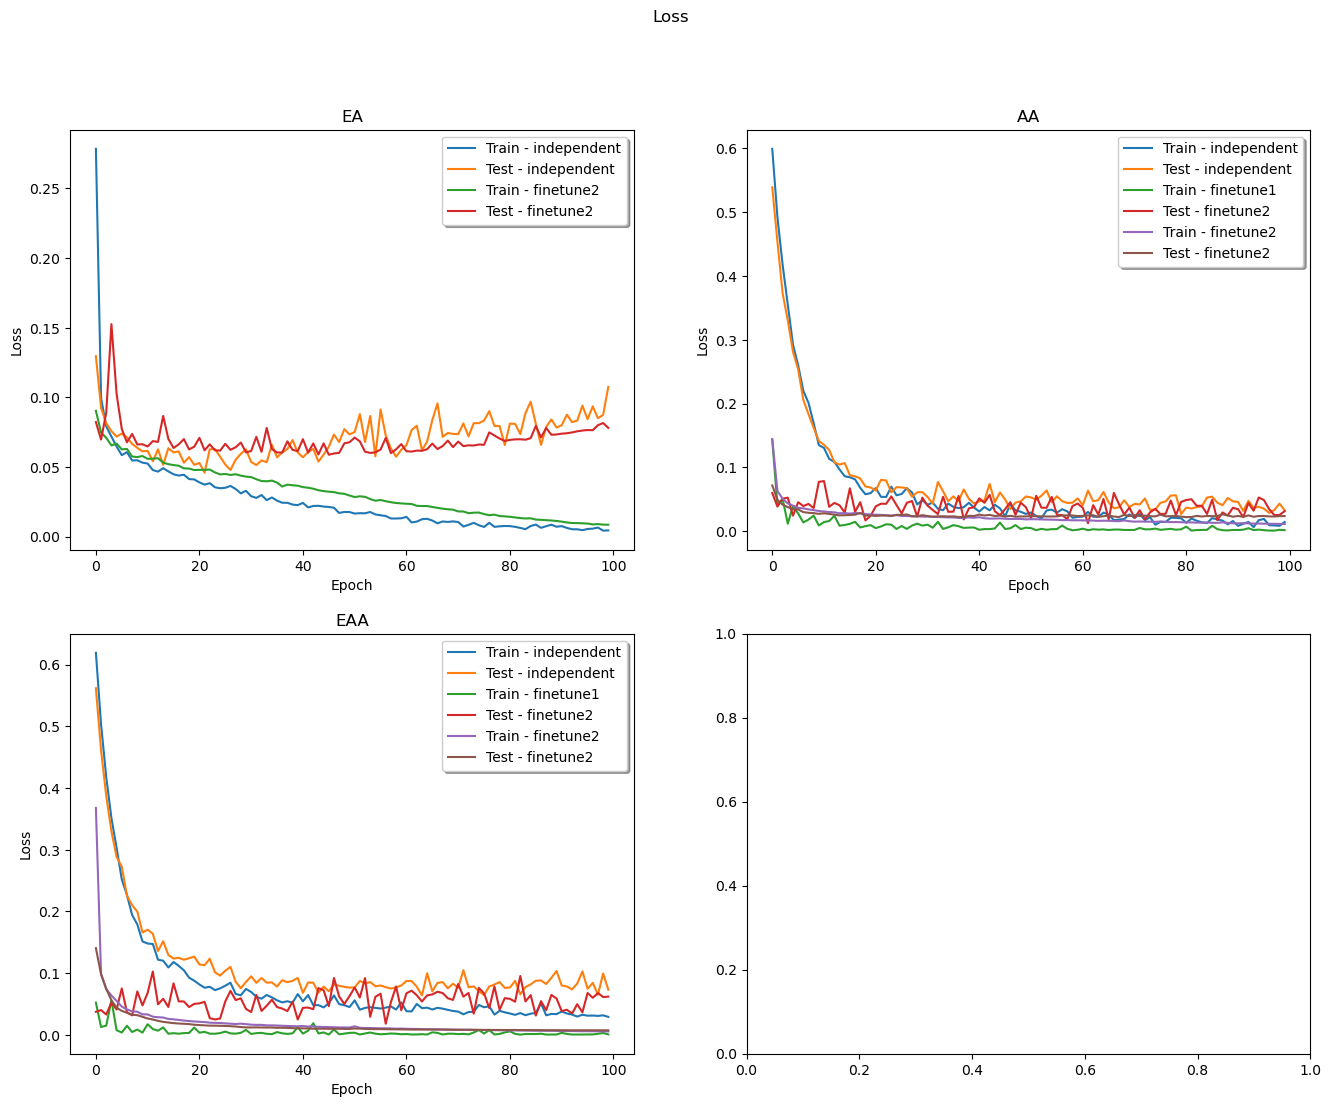

In [66]:
figure, axis = plt.subplots(2, 2, figsize = (16,12))
figure.suptitle('Loss')

# EA
axis[0, 0].plot(range(100), COAD_EA_train_loss, label = "Train - independent")
axis[0, 0].plot(range(100), COAD_EA_test_loss, label = "Test - independent")
axis[0, 0].plot(range(100), COAD_EA_train_loss2, label = "Train - finetune2")
axis[0, 0].plot(range(100), COAD_EA_test_loss2, label = "Test - finetune2")
axis[0, 0].set_title('EA')
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("Loss")
axis[0, 0].legend(shadow=True)


# AA
axis[0, 1].plot(range(100), COAD_AA_train_loss, label = "Train - independent")
axis[0, 1].plot(range(100), COAD_AA_test_loss, label = "Test - independent")
axis[0, 1].plot(range(100), COAD_AA_train_loss1, label = "Train - finetune1")
axis[0, 1].plot(range(100), COAD_AA_test_loss1, label = "Test - finetune2")
axis[0, 1].plot(range(100), COAD_AA_train_loss2, label = "Train - finetune2")
axis[0, 1].plot(range(100), COAD_AA_test_loss2, label = "Test - finetune2")
axis[0, 1].set_title('AA')
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("Loss")
axis[0, 1].legend(shadow=True)

  
# Test Recall
axis[1, 0].plot(range(100), COAD_EAA_train_loss, label = "Train - independent")
axis[1, 0].plot(range(100), COAD_EAA_test_loss, label = "Test - independent")
axis[1, 0].plot(range(100), COAD_EAA_train_loss1, label = "Train - finetune1")
axis[1, 0].plot(range(100), COAD_EAA_test_loss1, label = "Test - finetune2")
axis[1, 0].plot(range(100), COAD_EAA_train_loss2, label = "Train - finetune2")
axis[1, 0].plot(range(100), COAD_EAA_test_loss2, label = "Test - finetune2")
axis[1, 0].set_title('EAA')
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("Loss")
axis[1, 0].legend(shadow=True)

  
# Combine all the operations and display
plt.show()


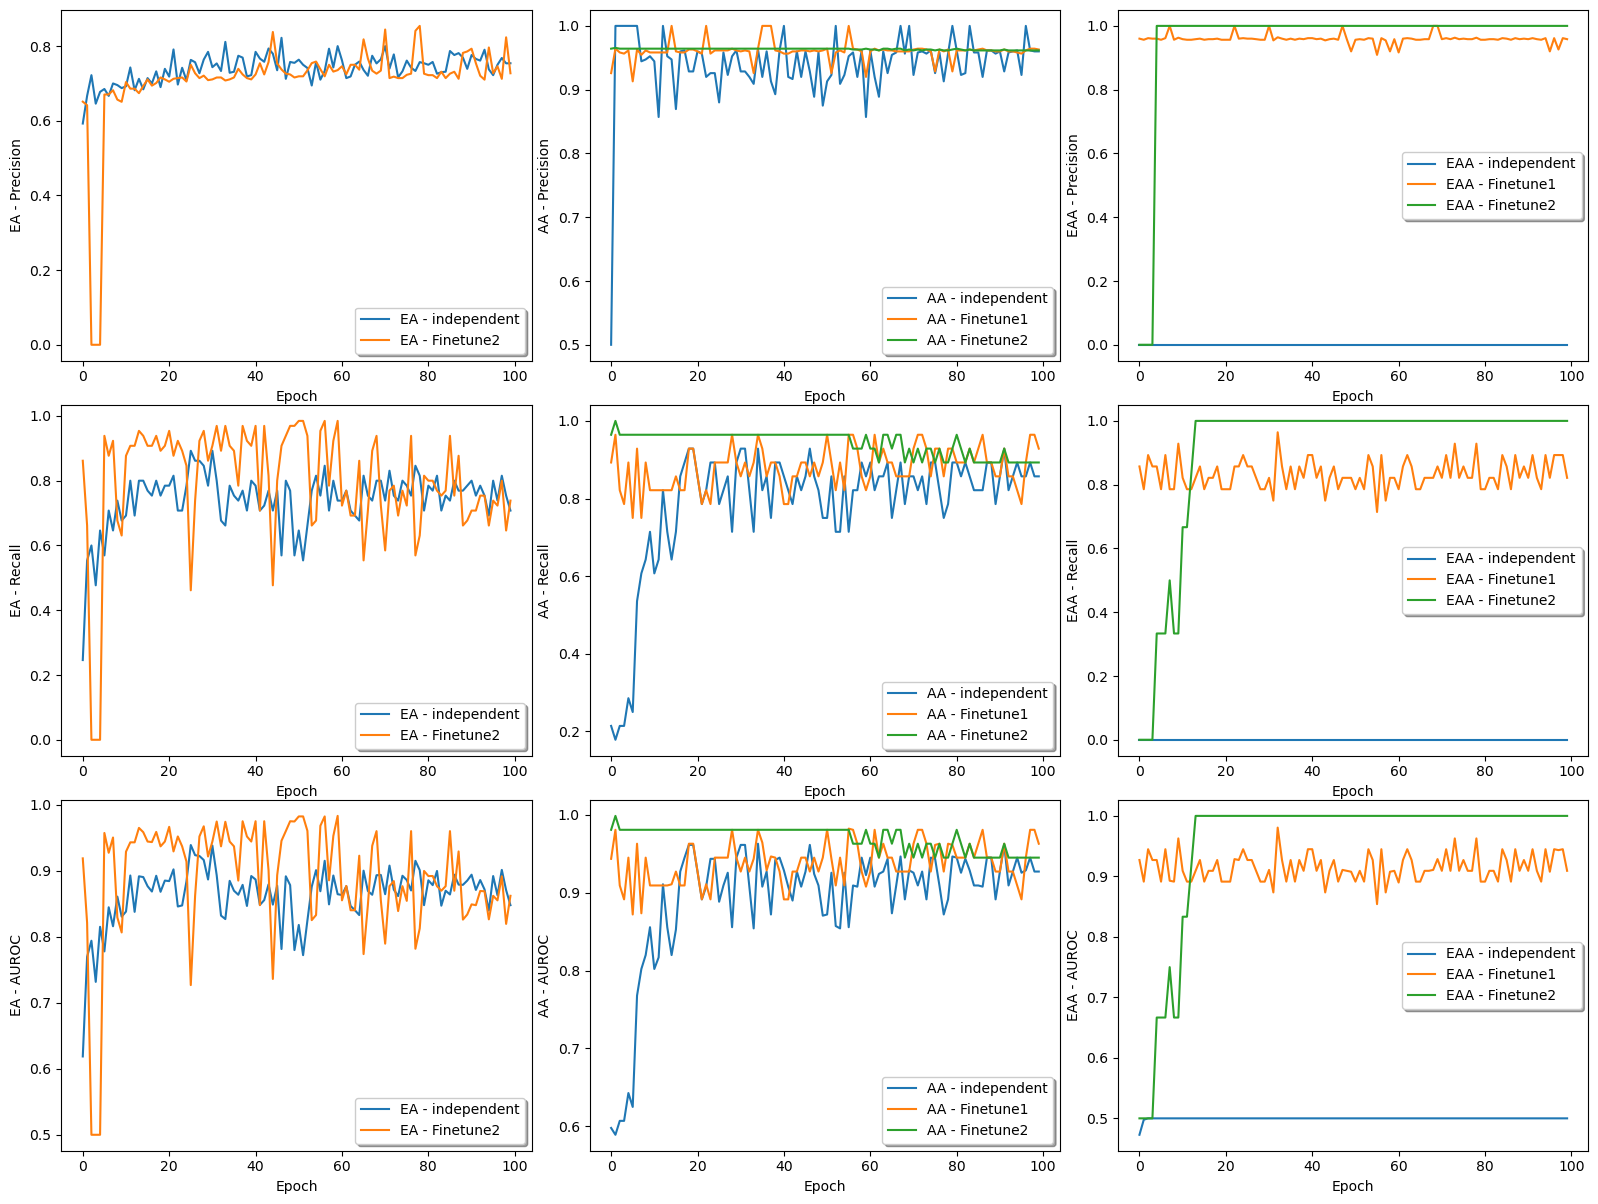

In [67]:
figure, axis = plt.subplots(3, 3, figsize = (16,12))
figure.tight_layout()

# Precision
axis[0, 0].plot(range(100), COAD_EA_precison, label = "EA - independent")
axis[0, 0].plot(range(100), COAD_EA_precison2, label = "EA - Finetune2")
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("EA - Precision")
axis[0, 0].legend(shadow=True)


axis[0, 1].plot(range(100), COAD_AA_precison, label = "AA - independent")
axis[0, 1].plot(range(100), COAD_AA_precison1, label = "AA - Finetune1")
axis[0, 1].plot(range(100), COAD_AA_precison2, label = "AA - Finetune2")
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("AA - Precision")
axis[0, 1].legend(shadow=True)


axis[0, 2].plot(range(100), COAD_EAA_precison, label = "EAA - independent")
axis[0, 2].plot(range(100), COAD_EAA_precison1, label = "EAA - Finetune1")
axis[0, 2].plot(range(100), COAD_EAA_precison2, label = "EAA - Finetune2")
axis[0, 2].set_xlabel("Epoch")
axis[0, 2].set_ylabel("EAA - Precision")
axis[0, 2].legend(shadow=True)


# Recall
axis[1, 0].plot(range(100), COAD_EA_recall, label = "EA - independent")
axis[1, 0].plot(range(100), COAD_EA_recall2, label = "EA - Finetune2")
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("EA - Recall")
axis[1, 0].legend(shadow=True)


axis[1, 1].plot(range(100), COAD_AA_recall, label = "AA - independent")
axis[1, 1].plot(range(100), COAD_AA_recall1, label = "AA - Finetune1")
axis[1, 1].plot(range(100), COAD_AA_recall2, label = "AA - Finetune2")
axis[1, 1].set_xlabel("Epoch")
axis[1, 1].set_ylabel("AA - Recall")
axis[1, 1].legend(shadow=True)


axis[1, 2].plot(range(100), COAD_EAA_recall, label = "EAA - independent")
axis[1, 2].plot(range(100), COAD_EAA_recall1, label = "EAA - Finetune1")
axis[1, 2].plot(range(100), COAD_EAA_recall2, label = "EAA - Finetune2")
axis[1, 2].set_xlabel("Epoch")
axis[1, 2].set_ylabel("EAA - Recall")
axis[1, 2].legend(shadow=True)

  
# Test Recall
axis[2, 0].plot(range(100), COAD_EA_AUC, label = "EA - independent")
axis[2, 0].plot(range(100), COAD_EA_AUC2, label = "EA - Finetune2")
axis[2, 0].set_xlabel("Epoch")
axis[2, 0].set_ylabel("EA - AUROC")
axis[2, 0].legend(shadow=True)

axis[2, 1].plot(range(100), COAD_AA_AUC, label = "AA - independent")
axis[2, 1].plot(range(100), COAD_AA_AUC1, label = "AA - Finetune1")
axis[2, 1].plot(range(100), COAD_AA_AUC2, label = "AA - Finetune2")
axis[2, 1].set_xlabel("Epoch")
axis[2, 1].set_ylabel("AA - AUROC")
axis[2, 1].legend(shadow=True)

axis[2, 2].plot(range(100), COAD_EAA_AUC, label = "EAA - independent")
axis[2, 2].plot(range(100), COAD_EAA_AUC1, label = "EAA - Finetune1")
axis[2, 2].plot(range(100), COAD_EAA_AUC2, label = "EAA - Finetune2")
axis[2, 2].set_xlabel("Epoch")
axis[2, 2].set_ylabel("EAA - AUROC")
axis[2, 2].legend(shadow=True)


### Training task: LIHC

In [68]:
LIHC = 1*np.array(mrna_protein_race['Cancer_type'] == 'LIHC')

select = SelectKBest(score_func=f_regression, k=200)
LIHC_mrna = select.fit_transform(MRNA_scale,LIHC)
LIHC_X = np.hstack((LIHC_mrna, np.matrix(protein_scale)))

# split train-test data
LIHC_EA_X = LIHC_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'EA'), ]
LIHC_EA_Y = LIHC[np.array(mrna_protein_race['EIGENSTRAT'] == 'EA')]
LIHC_AA_X = LIHC_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'AA'), ]
LIHC_AA_Y = LIHC[np.array(mrna_protein_race['EIGENSTRAT'] == 'AA')]
LIHC_EAA_X = LIHC_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'EAA'), ]
LIHC_EAA_Y = LIHC[np.array(mrna_protein_race['EIGENSTRAT'] == 'EAA')]

LIHC_X_train_EA, LIHC_X_test_EA, LIHC_Y_train_EA, LIHC_Y_test_EA = train_test_split(LIHC_EA_X, LIHC_EA_Y, stratify=LIHC_EA_Y, test_size=0.2, random_state=42)
LIHC_X_train_AA, LIHC_X_test_AA, LIHC_Y_train_AA, LIHC_Y_test_AA = train_test_split(LIHC_AA_X, LIHC_AA_Y, stratify=LIHC_AA_Y, test_size=0.5, random_state=42)
LIHC_X_train_EAA, LIHC_X_test_EAA, LIHC_Y_train_EAA, LIHC_Y_test_EAA = train_test_split(LIHC_EAA_X, LIHC_EAA_Y, stratify=LIHC_EAA_Y, test_size=0.5, random_state=42)


#### Independent

In [69]:
# Race EA
EA_net = DNN()
optimizer = torch.optim.SGD(EA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(LIHC_X_train_EA)), torch.from_numpy(LIHC_Y_train_EA))
LIHC_EA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(LIHC_X_test_EA)), torch.from_numpy(LIHC_Y_test_EA))
LIHC_EA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(LIHC_Y_test_EA), shuffle=True)

LIHC_EA_train_loss, LIHC_EA_test_loss, LIHC_EA_precison, LIHC_EA_recall, LIHC_EA_AUC = train(EA_net, LIHC_EA_train_loader, LIHC_EA_test_loader, 100)

# Race AA
AA_net = DNN()
optimizer = torch.optim.SGD(AA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(LIHC_X_train_AA)), torch.from_numpy(LIHC_Y_train_AA))
LIHC_AA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(LIHC_X_test_AA)), torch.from_numpy(LIHC_Y_test_AA))
LIHC_AA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(LIHC_Y_test_AA), shuffle=True)

LIHC_AA_train_loss, LIHC_AA_test_loss, LIHC_AA_precison, LIHC_AA_recall, LIHC_AA_AUC = train(AA_net, LIHC_AA_train_loader, LIHC_AA_test_loader, 100)

# Race EAA
EAA_net = DNN()
optimizer = torch.optim.SGD(EAA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(LIHC_X_train_EAA)), torch.from_numpy(LIHC_Y_train_EAA))
LIHC_EAA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(LIHC_X_test_EAA)), torch.from_numpy(LIHC_Y_test_EAA))
LIHC_EAA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(LIHC_Y_test_EAA), shuffle=True)

LIHC_EAA_train_loss, LIHC_EAA_test_loss, LIHC_EAA_precison, LIHC_EAA_recall, LIHC_EAA_AUC = train(EAA_net, LIHC_EAA_train_loader, LIHC_EAA_test_loader, 100)


#### Fine-tune 1

In [70]:
# AA
AA_net1 = EA_net
optimizer = torch.optim.SGD(AA_net1.parameters(), lr=0.002)
# new batch size
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(LIHC_X_train_AA)), torch.from_numpy(LIHC_Y_train_AA))
LIHC_AA_train_loader1 = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
# tune
LIHC_AA_train_loss1, LIHC_AA_test_loss1, LIHC_AA_precison1, LIHC_AA_recall1, LIHC_AA_AUC1 = train(AA_net1, LIHC_AA_train_loader1, LIHC_AA_test_loader, 100)

# EAA
EAA_net1 = EA_net
optimizer = torch.optim.SGD(EAA_net1.parameters(), lr=0.002)
# new batch size
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(LIHC_X_train_EAA)), torch.from_numpy(LIHC_Y_train_EAA))
LIHC_EAA_train_loader1 = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
# tune
LIHC_EAA_train_loss1, LIHC_EAA_test_loss1, LIHC_EAA_precison1, LIHC_EAA_recall1, LIHC_EAA_AUC1 = train(EAA_net1, LIHC_EAA_train_loader1, LIHC_AA_test_loader, 100)


#### Fine-tune 2

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classifica

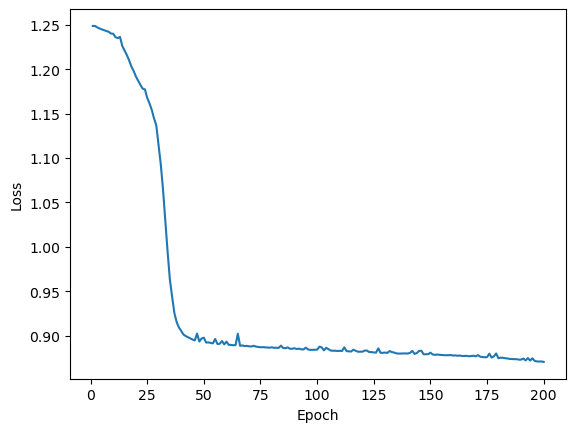

In [71]:
# train auto encoder using all available data
encoder1 = encoder()
decoder1 = decoder()
criterion=nn.MSELoss()
params_to_optimize = [{'params': encoder1.parameters()}, {'params': decoder1.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.01,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(LIHC_X)), torch.from_numpy(LIHC))
LIHC_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)

# train autoencoder
encoder_train(encoder1, decoder1, LIHC_train_loader)

# EA
encoder_EA = encoder1
finetune_EA = finetune()
params_to_optimize = [{'params': encoder_EA.parameters()}, {'params': finetune_EA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(LIHC_X_train_EA)), torch.from_numpy(LIHC_Y_train_EA))
LIHC_EA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
LIHC_EA_train_loss2, LIHC_EA_test_loss2, LIHC_EA_precison2, LIHC_EA_recall2, LIHC_EA_AUC2 = ft_train(encoder_EA, finetune_EA, LIHC_EA_train_loader, LIHC_EA_test_loader, 100)

# AA
encoder_AA = encoder1
finetune_AA = finetune()
params_to_optimize = [{'params': encoder_AA.parameters()}, {'params': finetune_AA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(LIHC_X_train_AA)), torch.from_numpy(LIHC_Y_train_AA))
LIHC_AA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
LIHC_AA_train_loss2, LIHC_AA_test_loss2, LIHC_AA_precison2, LIHC_AA_recall2, LIHC_AA_AUC2 = ft_train(encoder_AA, finetune_AA, LIHC_AA_train_loader, LIHC_AA_test_loader, 100)


# EAA
encoder_EAA = encoder1
finetune_EAA = finetune()
params_to_optimize = [{'params': encoder_EAA.parameters()}, {'params': finetune_EAA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(LIHC_X_train_EAA)), torch.from_numpy(LIHC_Y_train_EAA))
LIHC_EAA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
LIHC_EAA_train_loss2, LIHC_EAA_test_loss2, LIHC_EAA_precison2, LIHC_EAA_recall2, LIHC_EAA_AUC2 = ft_train(encoder_EAA, finetune_EAA, LIHC_EAA_train_loader, LIHC_EAA_test_loader, 100)


#### Plots

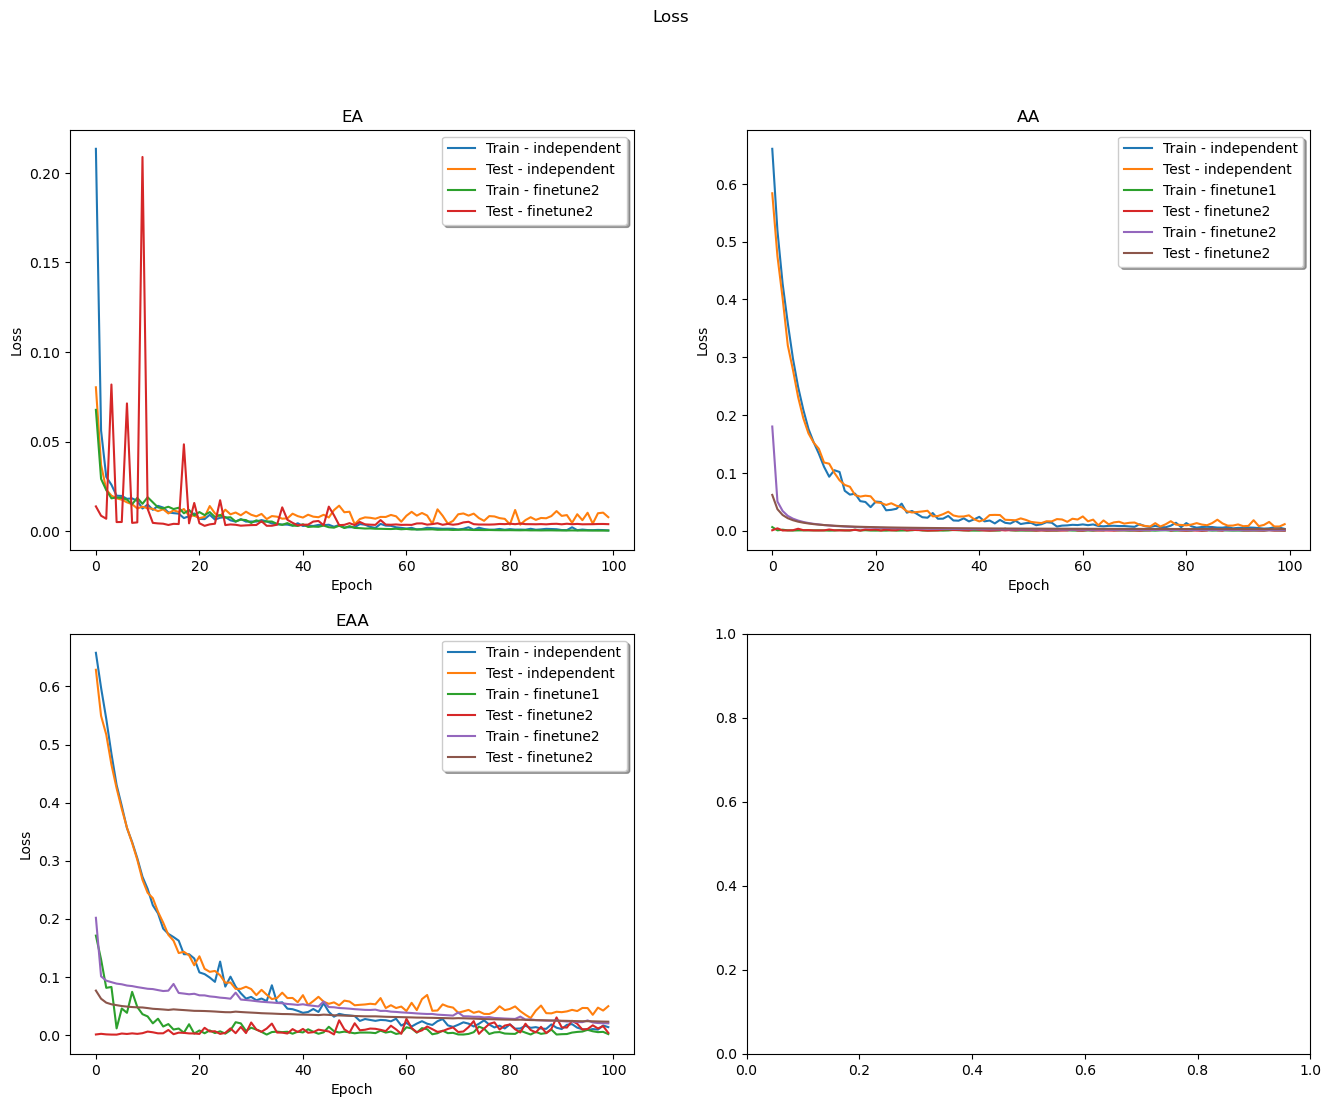

In [72]:
figure, axis = plt.subplots(2, 2, figsize = (16,12))
figure.suptitle('Loss')

# EA
axis[0, 0].plot(range(100), LIHC_EA_train_loss, label = "Train - independent")
axis[0, 0].plot(range(100), LIHC_EA_test_loss, label = "Test - independent")
axis[0, 0].plot(range(100), LIHC_EA_train_loss2, label = "Train - finetune2")
axis[0, 0].plot(range(100), LIHC_EA_test_loss2, label = "Test - finetune2")
axis[0, 0].set_title('EA')
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("Loss")
axis[0, 0].legend(shadow=True)


# AA
axis[0, 1].plot(range(100), LIHC_AA_train_loss, label = "Train - independent")
axis[0, 1].plot(range(100), LIHC_AA_test_loss, label = "Test - independent")
axis[0, 1].plot(range(100), LIHC_AA_train_loss1, label = "Train - finetune1")
axis[0, 1].plot(range(100), LIHC_AA_test_loss1, label = "Test - finetune2")
axis[0, 1].plot(range(100), LIHC_AA_train_loss2, label = "Train - finetune2")
axis[0, 1].plot(range(100), LIHC_AA_test_loss2, label = "Test - finetune2")
axis[0, 1].set_title('AA')
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("Loss")
axis[0, 1].legend(shadow=True)

  
# Test Recall
axis[1, 0].plot(range(100), LIHC_EAA_train_loss, label = "Train - independent")
axis[1, 0].plot(range(100), LIHC_EAA_test_loss, label = "Test - independent")
axis[1, 0].plot(range(100), LIHC_EAA_train_loss1, label = "Train - finetune1")
axis[1, 0].plot(range(100), LIHC_EAA_test_loss1, label = "Test - finetune2")
axis[1, 0].plot(range(100), LIHC_EAA_train_loss2, label = "Train - finetune2")
axis[1, 0].plot(range(100), LIHC_EAA_test_loss2, label = "Test - finetune2")
axis[1, 0].set_title('EAA')
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("Loss")
axis[1, 0].legend(shadow=True)

  
# Combine all the operations and display
plt.show()


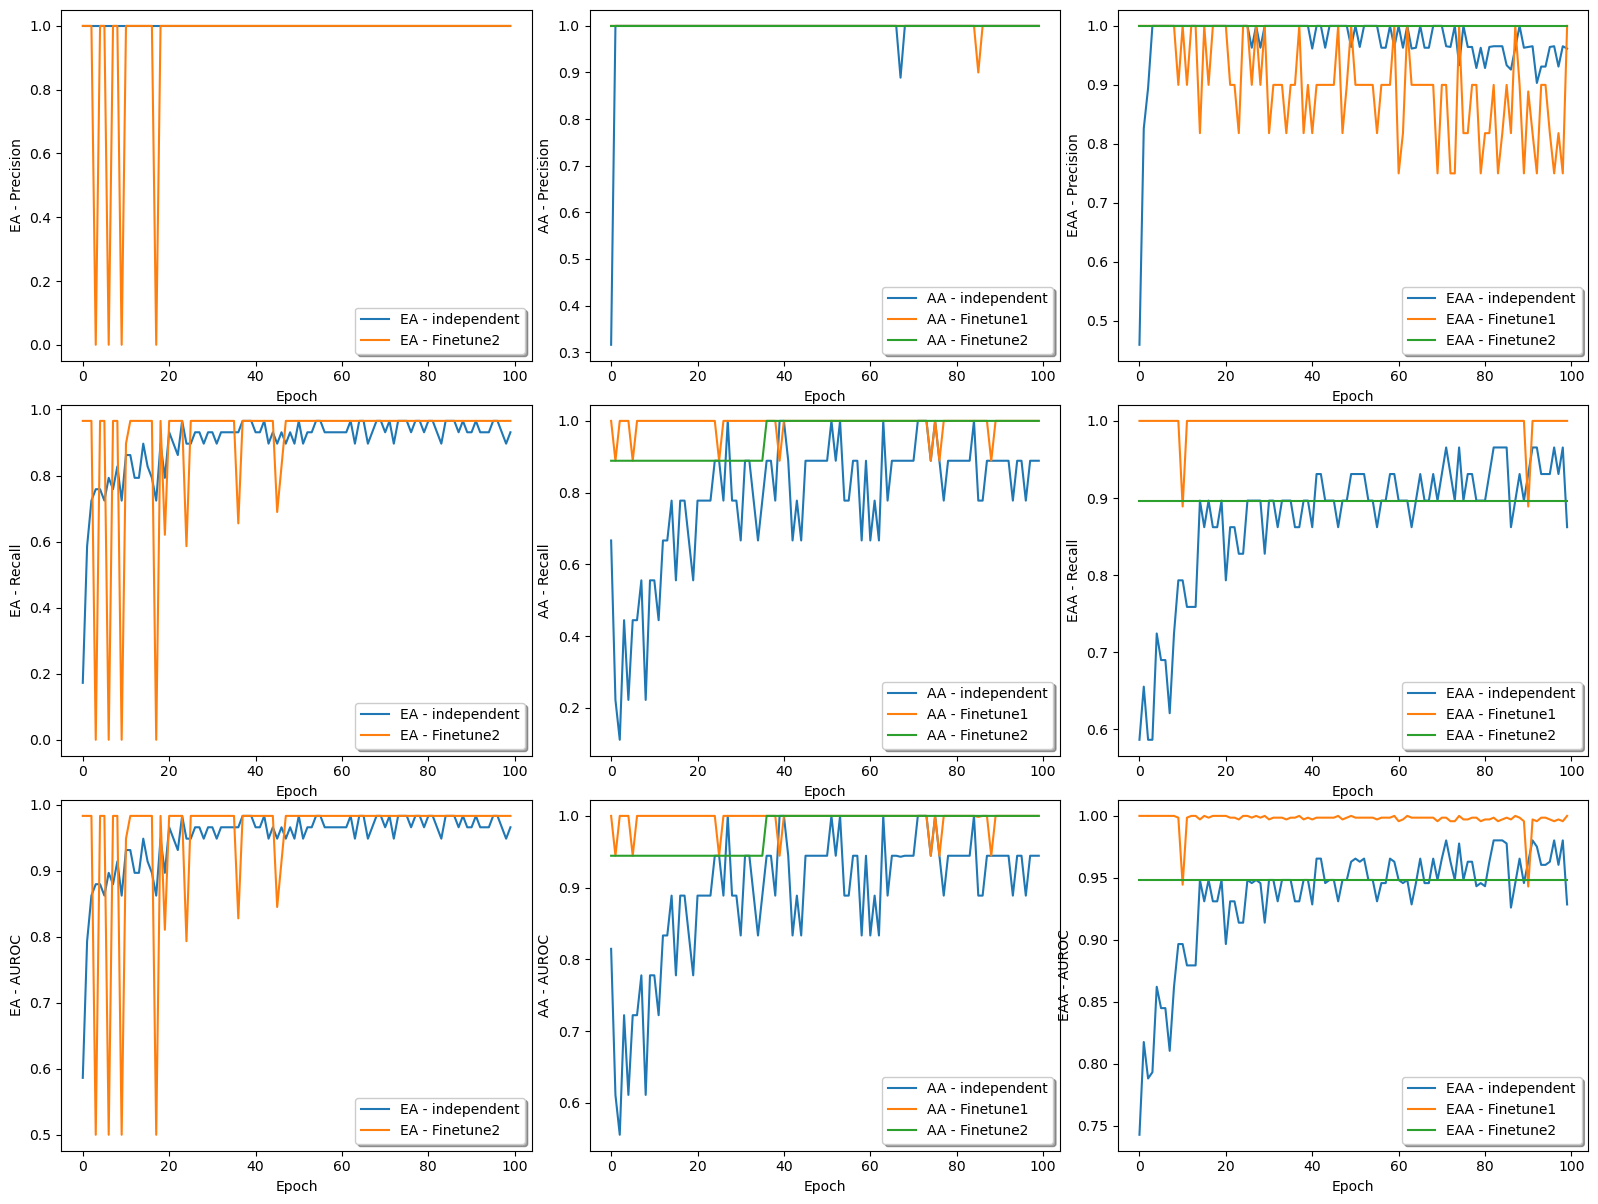

In [73]:
figure, axis = plt.subplots(3, 3, figsize = (16,12))
figure.tight_layout()

# Precision
axis[0, 0].plot(range(100), LIHC_EA_precison, label = "EA - independent")
axis[0, 0].plot(range(100), LIHC_EA_precison2, label = "EA - Finetune2")
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("EA - Precision")
axis[0, 0].legend(shadow=True)


axis[0, 1].plot(range(100), LIHC_AA_precison, label = "AA - independent")
axis[0, 1].plot(range(100), LIHC_AA_precison1, label = "AA - Finetune1")
axis[0, 1].plot(range(100), LIHC_AA_precison2, label = "AA - Finetune2")
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("AA - Precision")
axis[0, 1].legend(shadow=True)


axis[0, 2].plot(range(100), LIHC_EAA_precison, label = "EAA - independent")
axis[0, 2].plot(range(100), LIHC_EAA_precison1, label = "EAA - Finetune1")
axis[0, 2].plot(range(100), LIHC_EAA_precison2, label = "EAA - Finetune2")
axis[0, 2].set_xlabel("Epoch")
axis[0, 2].set_ylabel("EAA - Precision")
axis[0, 2].legend(shadow=True)


# Recall
axis[1, 0].plot(range(100), LIHC_EA_recall, label = "EA - independent")
axis[1, 0].plot(range(100), LIHC_EA_recall2, label = "EA - Finetune2")
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("EA - Recall")
axis[1, 0].legend(shadow=True)


axis[1, 1].plot(range(100), LIHC_AA_recall, label = "AA - independent")
axis[1, 1].plot(range(100), LIHC_AA_recall1, label = "AA - Finetune1")
axis[1, 1].plot(range(100), LIHC_AA_recall2, label = "AA - Finetune2")
axis[1, 1].set_xlabel("Epoch")
axis[1, 1].set_ylabel("AA - Recall")
axis[1, 1].legend(shadow=True)


axis[1, 2].plot(range(100), LIHC_EAA_recall, label = "EAA - independent")
axis[1, 2].plot(range(100), LIHC_EAA_recall1, label = "EAA - Finetune1")
axis[1, 2].plot(range(100), LIHC_EAA_recall2, label = "EAA - Finetune2")
axis[1, 2].set_xlabel("Epoch")
axis[1, 2].set_ylabel("EAA - Recall")
axis[1, 2].legend(shadow=True)

  
# Test Recall
axis[2, 0].plot(range(100), LIHC_EA_AUC, label = "EA - independent")
axis[2, 0].plot(range(100), LIHC_EA_AUC2, label = "EA - Finetune2")
axis[2, 0].set_xlabel("Epoch")
axis[2, 0].set_ylabel("EA - AUROC")
axis[2, 0].legend(shadow=True)

axis[2, 1].plot(range(100), LIHC_AA_AUC, label = "AA - independent")
axis[2, 1].plot(range(100), LIHC_AA_AUC1, label = "AA - Finetune1")
axis[2, 1].plot(range(100), LIHC_AA_AUC2, label = "AA - Finetune2")
axis[2, 1].set_xlabel("Epoch")
axis[2, 1].set_ylabel("AA - AUROC")
axis[2, 1].legend(shadow=True)

axis[2, 2].plot(range(100), LIHC_EAA_AUC, label = "EAA - independent")
axis[2, 2].plot(range(100), LIHC_EAA_AUC1, label = "EAA - Finetune1")
axis[2, 2].plot(range(100), LIHC_EAA_AUC2, label = "EAA - Finetune2")
axis[2, 2].set_xlabel("Epoch")
axis[2, 2].set_ylabel("EAA - AUROC")
axis[2, 2].legend(shadow=True)


### Learning Task: THCA

In [74]:
THCA = 1*np.array(mrna_protein_race['Cancer_type'] == 'THCA')

select = SelectKBest(score_func=f_regression, k=200)
THCA_mrna = select.fit_transform(MRNA_scale,THCA)
THCA_X = np.hstack((THCA_mrna, np.matrix(protein_scale)))

# split train-test data
THCA_EA_X = THCA_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'EA'), ]
THCA_EA_Y = THCA[np.array(mrna_protein_race['EIGENSTRAT'] == 'EA')]
THCA_AA_X = THCA_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'AA'), ]
THCA_AA_Y = THCA[np.array(mrna_protein_race['EIGENSTRAT'] == 'AA')]
THCA_EAA_X = THCA_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'EAA'), ]
THCA_EAA_Y = THCA[np.array(mrna_protein_race['EIGENSTRAT'] == 'EAA')]

THCA_X_train_EA, THCA_X_test_EA, THCA_Y_train_EA, THCA_Y_test_EA = train_test_split(THCA_EA_X, THCA_EA_Y, stratify=THCA_EA_Y, test_size=0.2, random_state=42)
THCA_X_train_AA, THCA_X_test_AA, THCA_Y_train_AA, THCA_Y_test_AA = train_test_split(THCA_AA_X, THCA_AA_Y, stratify=THCA_AA_Y, test_size=0.5, random_state=42)
THCA_X_train_EAA, THCA_X_test_EAA, THCA_Y_train_EAA, THCA_Y_test_EAA = train_test_split(THCA_EAA_X, THCA_EAA_Y, stratify=THCA_EAA_Y, test_size=0.5, random_state=42)


#### Independent

In [75]:
# Race EA
EA_net = DNN()
optimizer = torch.optim.SGD(EA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(THCA_X_train_EA)), torch.from_numpy(THCA_Y_train_EA))
THCA_EA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(THCA_X_test_EA)), torch.from_numpy(THCA_Y_test_EA))
THCA_EA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(THCA_Y_test_EA), shuffle=True)

THCA_EA_train_loss, THCA_EA_test_loss, THCA_EA_precison, THCA_EA_recall, THCA_EA_AUC = train(EA_net, THCA_EA_train_loader, THCA_EA_test_loader, 100)

# Race AA
AA_net = DNN()
optimizer = torch.optim.SGD(AA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(THCA_X_train_AA)), torch.from_numpy(THCA_Y_train_AA))
THCA_AA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(THCA_X_test_AA)), torch.from_numpy(THCA_Y_test_AA))
THCA_AA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(THCA_Y_test_AA), shuffle=True)

THCA_AA_train_loss, THCA_AA_test_loss, THCA_AA_precison, THCA_AA_recall, THCA_AA_AUC = train(AA_net, THCA_AA_train_loader, THCA_AA_test_loader, 100)

# Race EAA
EAA_net = DNN()
optimizer = torch.optim.SGD(EAA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(THCA_X_train_EAA)), torch.from_numpy(THCA_Y_train_EAA))
THCA_EAA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(THCA_X_test_EAA)), torch.from_numpy(THCA_Y_test_EAA))
THCA_EAA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(THCA_Y_test_EAA), shuffle=True)

THCA_EAA_train_loss, THCA_EAA_test_loss, THCA_EAA_precison, THCA_EAA_recall, THCA_EAA_AUC = train(EAA_net, THCA_EAA_train_loader, THCA_EAA_test_loader, 100)


/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classifica

#### Fine-tune 1

In [76]:
# AA
AA_net1 = EA_net
optimizer = torch.optim.SGD(AA_net1.parameters(), lr=0.002)
# new batch size
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(THCA_X_train_AA)), torch.from_numpy(THCA_Y_train_AA))
THCA_AA_train_loader1 = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
# tune
THCA_AA_train_loss1, THCA_AA_test_loss1, THCA_AA_precison1, THCA_AA_recall1, THCA_AA_AUC1 = train(AA_net1, THCA_AA_train_loader1, THCA_AA_test_loader, 100)

# EAA
EAA_net1 = EA_net
optimizer = torch.optim.SGD(EAA_net1.parameters(), lr=0.002)
# new batch size
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(THCA_X_train_EAA)), torch.from_numpy(THCA_Y_train_EAA))
THCA_EAA_train_loader1 = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
# tune
THCA_EAA_train_loss1, THCA_EAA_test_loss1, THCA_EAA_precison1, THCA_EAA_recall1, THCA_EAA_AUC1 = train(EAA_net1, THCA_EAA_train_loader1, THCA_AA_test_loader, 100)


#### Fine-tune 2

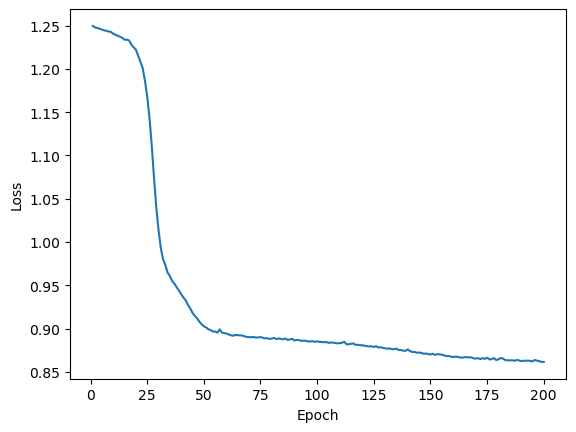

In [77]:
# train auto encoder using all available data
encoder1 = encoder()
decoder1 = decoder()
criterion=nn.MSELoss()
params_to_optimize = [{'params': encoder1.parameters()}, {'params': decoder1.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.01,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(THCA_X)), torch.from_numpy(THCA))
THCA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)

# train autoencoder
encoder_train(encoder1, decoder1, THCA_train_loader)

# EA
encoder_EA = encoder1
finetune_EA = finetune()
params_to_optimize = [{'params': encoder_EA.parameters()}, {'params': finetune_EA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(THCA_X_train_EA)), torch.from_numpy(THCA_Y_train_EA))
THCA_EA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
THCA_EA_train_loss2, THCA_EA_test_loss2, THCA_EA_precison2, THCA_EA_recall2, THCA_EA_AUC2 = ft_train(encoder_EA, finetune_EA, THCA_EA_train_loader, THCA_EA_test_loader, 100)

# AA
encoder_AA = encoder1
finetune_AA = finetune()
params_to_optimize = [{'params': encoder_AA.parameters()}, {'params': finetune_AA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(THCA_X_train_AA)), torch.from_numpy(THCA_Y_train_AA))
THCA_AA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
THCA_AA_train_loss2, THCA_AA_test_loss2, THCA_AA_precison2, THCA_AA_recall2, THCA_AA_AUC2 = ft_train(encoder_AA, finetune_AA, THCA_AA_train_loader, THCA_AA_test_loader, 100)


# EAA
encoder_EAA = encoder1
finetune_EAA = finetune()
params_to_optimize = [{'params': encoder_EAA.parameters()}, {'params': finetune_EAA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(THCA_X_train_EAA)), torch.from_numpy(THCA_Y_train_EAA))
THCA_EAA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
THCA_EAA_train_loss2, THCA_EAA_test_loss2, THCA_EAA_precison2, THCA_EAA_recall2, THCA_EAA_AUC2 = ft_train(encoder_EAA, finetune_EAA, THCA_EAA_train_loader, THCA_EAA_test_loader, 100)


#### Plots

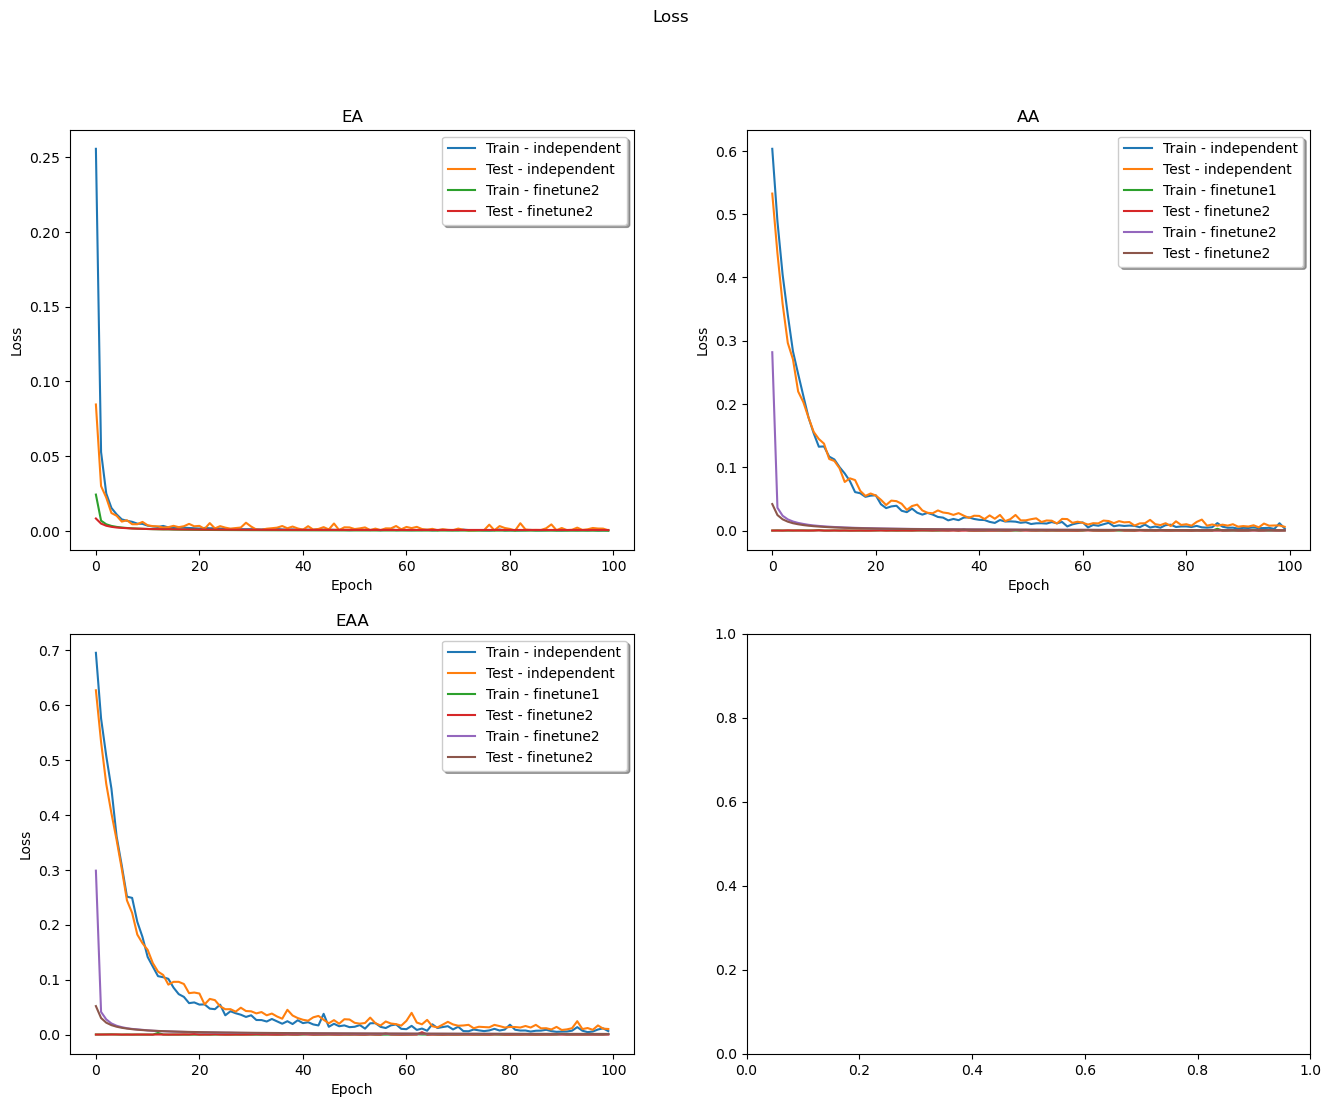

In [78]:
figure, axis = plt.subplots(2, 2, figsize = (16,12))
figure.suptitle('Loss')

# EA
axis[0, 0].plot(range(100), THCA_EA_train_loss, label = "Train - independent")
axis[0, 0].plot(range(100), THCA_EA_test_loss, label = "Test - independent")
axis[0, 0].plot(range(100), THCA_EA_train_loss2, label = "Train - finetune2")
axis[0, 0].plot(range(100), THCA_EA_test_loss2, label = "Test - finetune2")
axis[0, 0].set_title('EA')
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("Loss")
axis[0, 0].legend(shadow=True)


# AA
axis[0, 1].plot(range(100), THCA_AA_train_loss, label = "Train - independent")
axis[0, 1].plot(range(100), THCA_AA_test_loss, label = "Test - independent")
axis[0, 1].plot(range(100), THCA_AA_train_loss1, label = "Train - finetune1")
axis[0, 1].plot(range(100), THCA_AA_test_loss1, label = "Test - finetune2")
axis[0, 1].plot(range(100), THCA_AA_train_loss2, label = "Train - finetune2")
axis[0, 1].plot(range(100), THCA_AA_test_loss2, label = "Test - finetune2")
axis[0, 1].set_title('AA')
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("Loss")
axis[0, 1].legend(shadow=True)

  
# Test Recall
axis[1, 0].plot(range(100), THCA_EAA_train_loss, label = "Train - independent")
axis[1, 0].plot(range(100), THCA_EAA_test_loss, label = "Test - independent")
axis[1, 0].plot(range(100), THCA_EAA_train_loss1, label = "Train - finetune1")
axis[1, 0].plot(range(100), THCA_EAA_test_loss1, label = "Test - finetune2")
axis[1, 0].plot(range(100), THCA_EAA_train_loss2, label = "Train - finetune2")
axis[1, 0].plot(range(100), THCA_EAA_test_loss2, label = "Test - finetune2")
axis[1, 0].set_title('EAA')
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("Loss")
axis[1, 0].legend(shadow=True)

  
# Combine all the operations and display
plt.show()


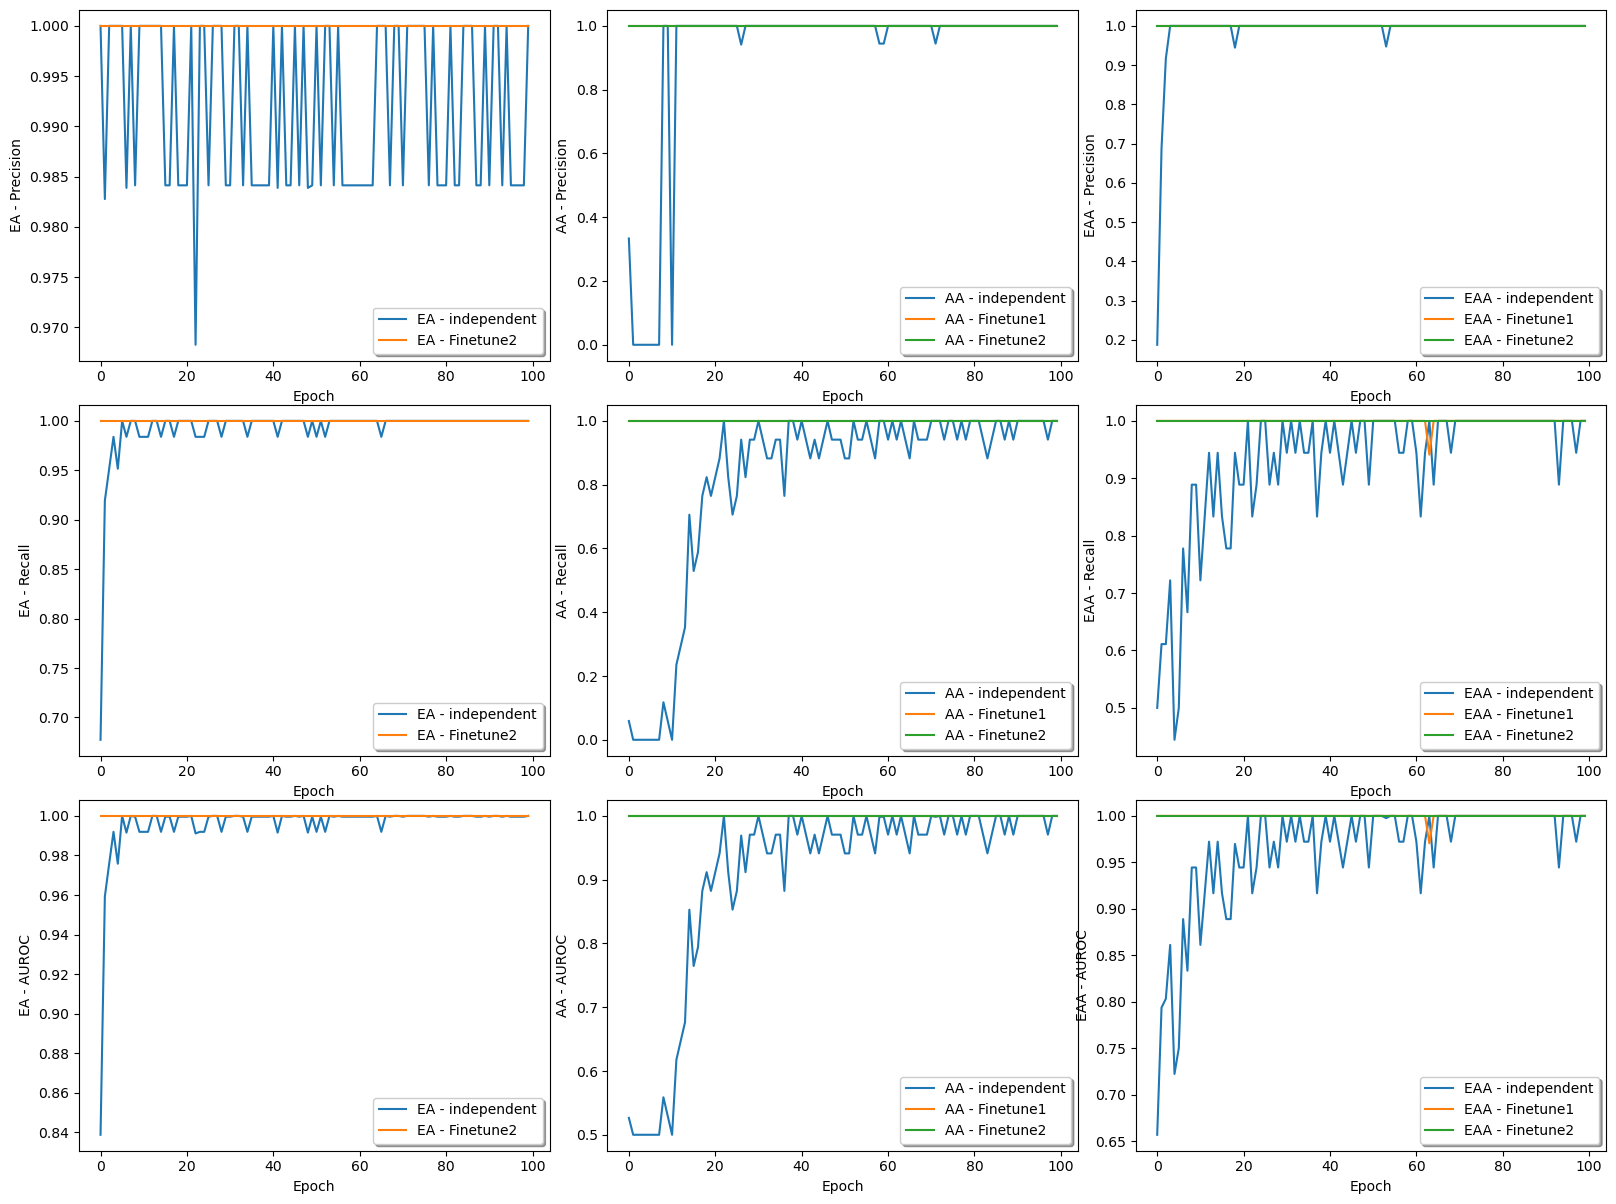

In [79]:
figure, axis = plt.subplots(3, 3, figsize = (16,12))
figure.tight_layout()

# Precision
axis[0, 0].plot(range(100), THCA_EA_precison, label = "EA - independent")
axis[0, 0].plot(range(100), THCA_EA_precison2, label = "EA - Finetune2")
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("EA - Precision")
axis[0, 0].legend(shadow=True)


axis[0, 1].plot(range(100), THCA_AA_precison, label = "AA - independent")
axis[0, 1].plot(range(100), THCA_AA_precison1, label = "AA - Finetune1")
axis[0, 1].plot(range(100), THCA_AA_precison2, label = "AA - Finetune2")
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("AA - Precision")
axis[0, 1].legend(shadow=True)


axis[0, 2].plot(range(100), THCA_EAA_precison, label = "EAA - independent")
axis[0, 2].plot(range(100), THCA_EAA_precison1, label = "EAA - Finetune1")
axis[0, 2].plot(range(100), THCA_EAA_precison2, label = "EAA - Finetune2")
axis[0, 2].set_xlabel("Epoch")
axis[0, 2].set_ylabel("EAA - Precision")
axis[0, 2].legend(shadow=True)


# Recall
axis[1, 0].plot(range(100), THCA_EA_recall, label = "EA - independent")
axis[1, 0].plot(range(100), THCA_EA_recall2, label = "EA - Finetune2")
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("EA - Recall")
axis[1, 0].legend(shadow=True)


axis[1, 1].plot(range(100), THCA_AA_recall, label = "AA - independent")
axis[1, 1].plot(range(100), THCA_AA_recall1, label = "AA - Finetune1")
axis[1, 1].plot(range(100), THCA_AA_recall2, label = "AA - Finetune2")
axis[1, 1].set_xlabel("Epoch")
axis[1, 1].set_ylabel("AA - Recall")
axis[1, 1].legend(shadow=True)


axis[1, 2].plot(range(100), THCA_EAA_recall, label = "EAA - independent")
axis[1, 2].plot(range(100), THCA_EAA_recall1, label = "EAA - Finetune1")
axis[1, 2].plot(range(100), THCA_EAA_recall2, label = "EAA - Finetune2")
axis[1, 2].set_xlabel("Epoch")
axis[1, 2].set_ylabel("EAA - Recall")
axis[1, 2].legend(shadow=True)

  
# Test Recall
axis[2, 0].plot(range(100), THCA_EA_AUC, label = "EA - independent")
axis[2, 0].plot(range(100), THCA_EA_AUC2, label = "EA - Finetune2")
axis[2, 0].set_xlabel("Epoch")
axis[2, 0].set_ylabel("EA - AUROC")
axis[2, 0].legend(shadow=True)

axis[2, 1].plot(range(100), THCA_AA_AUC, label = "AA - independent")
axis[2, 1].plot(range(100), THCA_AA_AUC1, label = "AA - Finetune1")
axis[2, 1].plot(range(100), THCA_AA_AUC2, label = "AA - Finetune2")
axis[2, 1].set_xlabel("Epoch")
axis[2, 1].set_ylabel("AA - AUROC")
axis[2, 1].legend(shadow=True)

axis[2, 2].plot(range(100), THCA_EAA_AUC, label = "EAA - independent")
axis[2, 2].plot(range(100), THCA_EAA_AUC1, label = "EAA - Finetune1")
axis[2, 2].plot(range(100), THCA_EAA_AUC2, label = "EAA - Finetune2")
axis[2, 2].set_xlabel("Epoch")
axis[2, 2].set_ylabel("EAA - AUROC")
axis[2, 2].legend(shadow=True)


### Learning Task: UCEC

In [80]:
UCEC = 1*np.array(mrna_protein_race['Cancer_type'] == 'UCEC')

select = SelectKBest(score_func=f_regression, k=200)
UCEC_mrna = select.fit_transform(MRNA_scale,UCEC)
UCEC_X = np.hstack((UCEC_mrna, np.matrix(protein_scale)))

# split train-test data
UCEC_EA_X = UCEC_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'EA'), ]
UCEC_EA_Y = UCEC[np.array(mrna_protein_race['EIGENSTRAT'] == 'EA')]
UCEC_AA_X = UCEC_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'AA'), ]
UCEC_AA_Y = UCEC[np.array(mrna_protein_race['EIGENSTRAT'] == 'AA')]
UCEC_EAA_X = UCEC_X[np.array(mrna_protein_race['EIGENSTRAT'] == 'EAA'), ]
UCEC_EAA_Y = UCEC[np.array(mrna_protein_race['EIGENSTRAT'] == 'EAA')]

UCEC_X_train_EA, UCEC_X_test_EA, UCEC_Y_train_EA, UCEC_Y_test_EA = train_test_split(UCEC_EA_X, UCEC_EA_Y, stratify=UCEC_EA_Y, test_size=0.2, random_state=42)
UCEC_X_train_AA, UCEC_X_test_AA, UCEC_Y_train_AA, UCEC_Y_test_AA = train_test_split(UCEC_AA_X, UCEC_AA_Y, stratify=UCEC_AA_Y, test_size=0.5, random_state=42)
UCEC_X_train_EAA, UCEC_X_test_EAA, UCEC_Y_train_EAA, UCEC_Y_test_EAA = train_test_split(UCEC_EAA_X, UCEC_EAA_Y, stratify=UCEC_EAA_Y, test_size=0.5, random_state=42)



#### Independent

In [81]:
# Race EA
EA_net = DNN()
optimizer = torch.optim.SGD(EA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(UCEC_X_train_EA)), torch.from_numpy(UCEC_Y_train_EA))
UCEC_EA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(UCEC_X_test_EA)), torch.from_numpy(UCEC_Y_test_EA))
UCEC_EA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(UCEC_Y_test_EA), shuffle=True)

UCEC_EA_train_loss, UCEC_EA_test_loss, UCEC_EA_precison, UCEC_EA_recall, UCEC_EA_AUC = train(EA_net, UCEC_EA_train_loader, UCEC_EA_test_loader, 100)

# Race AA
AA_net = DNN()
optimizer = torch.optim.SGD(AA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(UCEC_X_train_AA)), torch.from_numpy(UCEC_Y_train_AA))
UCEC_AA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(UCEC_X_test_AA)), torch.from_numpy(UCEC_Y_test_AA))
UCEC_AA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(UCEC_Y_test_AA), shuffle=True)

UCEC_AA_train_loss, UCEC_AA_test_loss, UCEC_AA_precison, UCEC_AA_recall, UCEC_AA_AUC = train(AA_net, UCEC_AA_train_loader, UCEC_AA_test_loader, 100)

# Race EAA
EAA_net = DNN()
optimizer = torch.optim.SGD(EAA_net.parameters(), lr=0.01)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(UCEC_X_train_EAA)), torch.from_numpy(UCEC_Y_train_EAA))
UCEC_EAA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# test set is very small, using batch size = sample size just for evaluation purpose
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(UCEC_X_test_EAA)), torch.from_numpy(UCEC_Y_test_EAA))
UCEC_EAA_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(UCEC_Y_test_EAA), shuffle=True)

UCEC_EAA_train_loss, UCEC_EAA_test_loss, UCEC_EAA_precison, UCEC_EAA_recall, UCEC_EAA_AUC = train(EAA_net, UCEC_EAA_train_loader, UCEC_EAA_test_loader, 100)


/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classifica

#### Fine-tune 1

In [82]:
# AA
AA_net1 = EA_net
optimizer = torch.optim.SGD(AA_net1.parameters(), lr=0.002)
# new batch size
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(UCEC_X_train_AA)), torch.from_numpy(UCEC_Y_train_AA))
UCEC_AA_train_loader1 = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
# tune
UCEC_AA_train_loss1, UCEC_AA_test_loss1, UCEC_AA_precison1, UCEC_AA_recall1, UCEC_AA_AUC1 = train(AA_net1, UCEC_AA_train_loader1, UCEC_AA_test_loader, 100)

# EAA
EAA_net1 = EA_net
optimizer = torch.optim.SGD(EAA_net1.parameters(), lr=0.002)
# new batch size
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(UCEC_X_train_EAA)), torch.from_numpy(UCEC_Y_train_EAA))
UCEC_EAA_train_loader1 = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
# tune
UCEC_EAA_train_loss1, UCEC_EAA_test_loss1, UCEC_EAA_precison1, UCEC_EAA_recall1, UCEC_EAA_AUC1 = train(EAA_net1, UCEC_EAA_train_loader1, UCEC_AA_test_loader, 100)


#### Fine-tune 2

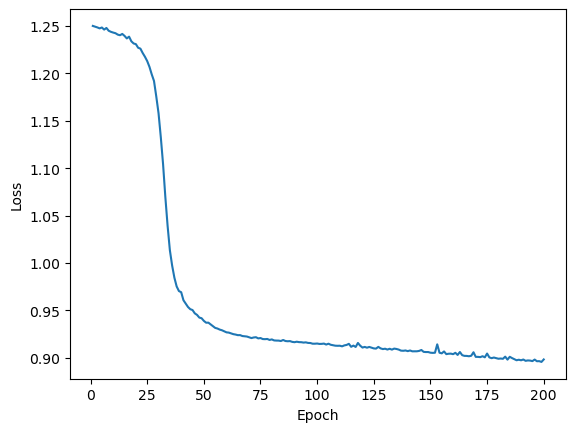

In [83]:
# train auto encoder using all available data
encoder1 = encoder()
decoder1 = decoder()
criterion=nn.MSELoss()
params_to_optimize = [{'params': encoder1.parameters()}, {'params': decoder1.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.01,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(UCEC_X)), torch.from_numpy(UCEC))
UCEC_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)

# train autoencoder
encoder_train(encoder1, decoder1, UCEC_train_loader)

# EA
encoder_EA = encoder1
finetune_EA = finetune()
params_to_optimize = [{'params': encoder_EA.parameters()}, {'params': finetune_EA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(UCEC_X_train_EA)), torch.from_numpy(UCEC_Y_train_EA))
UCEC_EA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
UCEC_EA_train_loss2, UCEC_EA_test_loss2, UCEC_EA_precison2, UCEC_EA_recall2, UCEC_EA_AUC2 = ft_train(encoder_EA, finetune_EA, UCEC_EA_train_loader, UCEC_EA_test_loader, 100)

# AA
encoder_AA = encoder1
finetune_AA = finetune()
params_to_optimize = [{'params': encoder_AA.parameters()}, {'params': finetune_AA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(UCEC_X_train_AA)), torch.from_numpy(UCEC_Y_train_AA))
UCEC_AA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
UCEC_AA_train_loss2, UCEC_AA_test_loss2, UCEC_AA_precison2, UCEC_AA_recall2, UCEC_AA_AUC2 = ft_train(encoder_AA, finetune_AA, UCEC_AA_train_loader, UCEC_AA_test_loader, 100)


# EAA
encoder_EAA = encoder1
finetune_EAA = finetune()
params_to_optimize = [{'params': encoder_EAA.parameters()}, {'params': finetune_EAA.parameters()}]
optimizer=optim.SGD(params_to_optimize,lr=0.002,weight_decay=1e-5)

# data loader
training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.float32(UCEC_X_train_EAA)), torch.from_numpy(UCEC_Y_train_EAA))
UCEC_EAA_train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)

# training
UCEC_EAA_train_loss2, UCEC_EAA_test_loss2, UCEC_EAA_precison2, UCEC_EAA_recall2, UCEC_EAA_AUC2 = ft_train(encoder_EAA, finetune_EAA, UCEC_EAA_train_loader, UCEC_EAA_test_loader, 100)


#### Plots

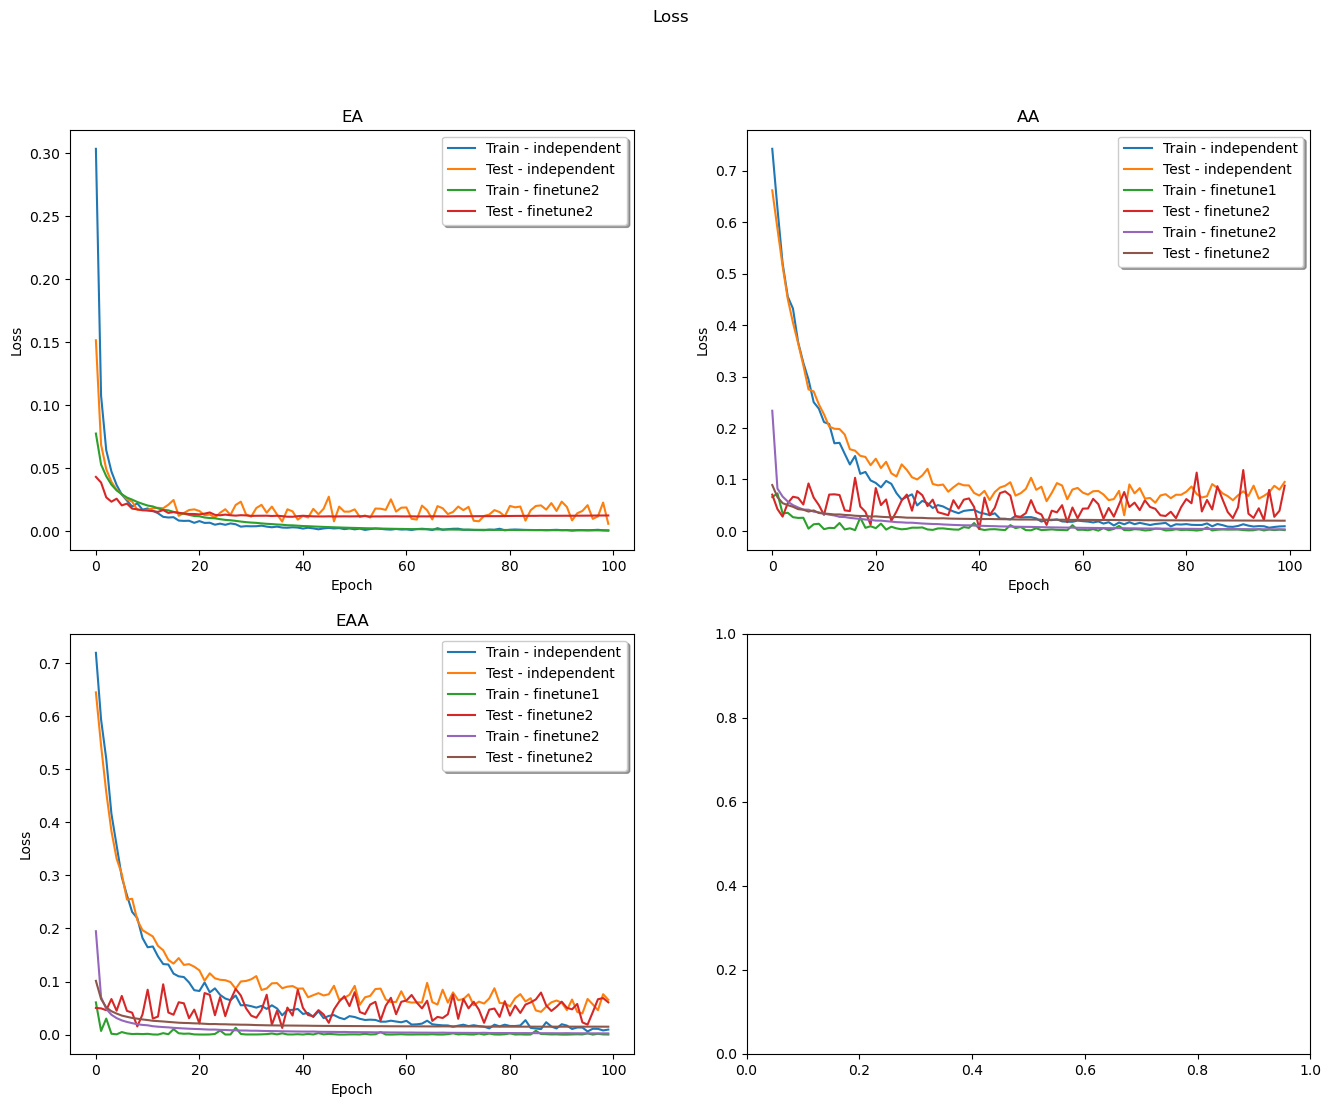

In [84]:
figure, axis = plt.subplots(2, 2, figsize = (16,12))
figure.suptitle('Loss')

# EA
axis[0, 0].plot(range(100), UCEC_EA_train_loss, label = "Train - independent")
axis[0, 0].plot(range(100), UCEC_EA_test_loss, label = "Test - independent")
axis[0, 0].plot(range(100), UCEC_EA_train_loss2, label = "Train - finetune2")
axis[0, 0].plot(range(100), UCEC_EA_test_loss2, label = "Test - finetune2")
axis[0, 0].set_title('EA')
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("Loss")
axis[0, 0].legend(shadow=True)


# AA
axis[0, 1].plot(range(100), UCEC_AA_train_loss, label = "Train - independent")
axis[0, 1].plot(range(100), UCEC_AA_test_loss, label = "Test - independent")
axis[0, 1].plot(range(100), UCEC_AA_train_loss1, label = "Train - finetune1")
axis[0, 1].plot(range(100), UCEC_AA_test_loss1, label = "Test - finetune2")
axis[0, 1].plot(range(100), UCEC_AA_train_loss2, label = "Train - finetune2")
axis[0, 1].plot(range(100), UCEC_AA_test_loss2, label = "Test - finetune2")
axis[0, 1].set_title('AA')
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("Loss")
axis[0, 1].legend(shadow=True)

  
# Test Recall
axis[1, 0].plot(range(100), UCEC_EAA_train_loss, label = "Train - independent")
axis[1, 0].plot(range(100), UCEC_EAA_test_loss, label = "Test - independent")
axis[1, 0].plot(range(100), UCEC_EAA_train_loss1, label = "Train - finetune1")
axis[1, 0].plot(range(100), UCEC_EAA_test_loss1, label = "Test - finetune2")
axis[1, 0].plot(range(100), UCEC_EAA_train_loss2, label = "Train - finetune2")
axis[1, 0].plot(range(100), UCEC_EAA_test_loss2, label = "Test - finetune2")
axis[1, 0].set_title('EAA')
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("Loss")
axis[1, 0].legend(shadow=True)

  
# Combine all the operations and display
plt.show()


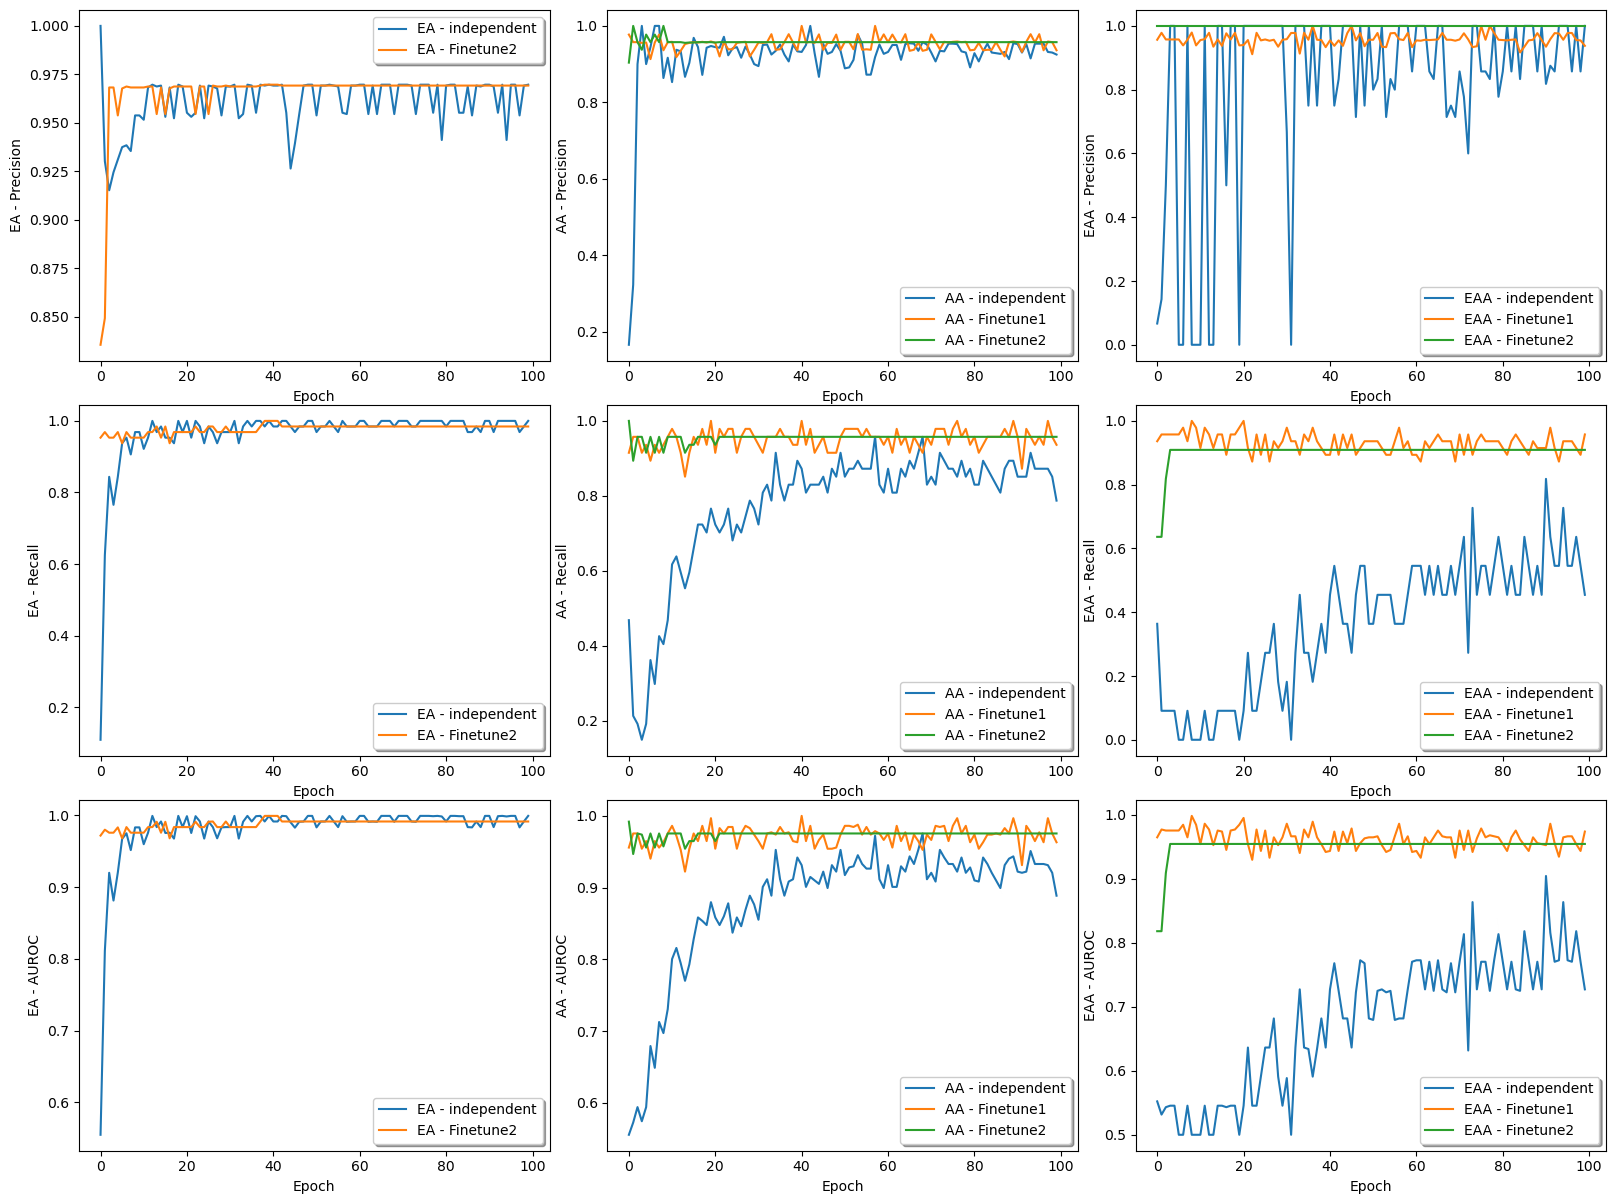

In [85]:
figure, axis = plt.subplots(3, 3, figsize = (16,12))
figure.tight_layout()

# Precision
axis[0, 0].plot(range(100), UCEC_EA_precison, label = "EA - independent")
axis[0, 0].plot(range(100), UCEC_EA_precison2, label = "EA - Finetune2")
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("EA - Precision")
axis[0, 0].legend(shadow=True)


axis[0, 1].plot(range(100), UCEC_AA_precison, label = "AA - independent")
axis[0, 1].plot(range(100), UCEC_AA_precison1, label = "AA - Finetune1")
axis[0, 1].plot(range(100), UCEC_AA_precison2, label = "AA - Finetune2")
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("AA - Precision")
axis[0, 1].legend(shadow=True)


axis[0, 2].plot(range(100), UCEC_EAA_precison, label = "EAA - independent")
axis[0, 2].plot(range(100), UCEC_EAA_precison1, label = "EAA - Finetune1")
axis[0, 2].plot(range(100), UCEC_EAA_precison2, label = "EAA - Finetune2")
axis[0, 2].set_xlabel("Epoch")
axis[0, 2].set_ylabel("EAA - Precision")
axis[0, 2].legend(shadow=True)


# Recall
axis[1, 0].plot(range(100), UCEC_EA_recall, label = "EA - independent")
axis[1, 0].plot(range(100), UCEC_EA_recall2, label = "EA - Finetune2")
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("EA - Recall")
axis[1, 0].legend(shadow=True)


axis[1, 1].plot(range(100), UCEC_AA_recall, label = "AA - independent")
axis[1, 1].plot(range(100), UCEC_AA_recall1, label = "AA - Finetune1")
axis[1, 1].plot(range(100), UCEC_AA_recall2, label = "AA - Finetune2")
axis[1, 1].set_xlabel("Epoch")
axis[1, 1].set_ylabel("AA - Recall")
axis[1, 1].legend(shadow=True)


axis[1, 2].plot(range(100), UCEC_EAA_recall, label = "EAA - independent")
axis[1, 2].plot(range(100), UCEC_EAA_recall1, label = "EAA - Finetune1")
axis[1, 2].plot(range(100), UCEC_EAA_recall2, label = "EAA - Finetune2")
axis[1, 2].set_xlabel("Epoch")
axis[1, 2].set_ylabel("EAA - Recall")
axis[1, 2].legend(shadow=True)

  
# Test Recall
axis[2, 0].plot(range(100), UCEC_EA_AUC, label = "EA - independent")
axis[2, 0].plot(range(100), UCEC_EA_AUC2, label = "EA - Finetune2")
axis[2, 0].set_xlabel("Epoch")
axis[2, 0].set_ylabel("EA - AUROC")
axis[2, 0].legend(shadow=True)

axis[2, 1].plot(range(100), UCEC_AA_AUC, label = "AA - independent")
axis[2, 1].plot(range(100), UCEC_AA_AUC1, label = "AA - Finetune1")
axis[2, 1].plot(range(100), UCEC_AA_AUC2, label = "AA - Finetune2")
axis[2, 1].set_xlabel("Epoch")
axis[2, 1].set_ylabel("AA - AUROC")
axis[2, 1].legend(shadow=True)

axis[2, 2].plot(range(100), UCEC_EAA_AUC, label = "EAA - independent")
axis[2, 2].plot(range(100), UCEC_EAA_AUC1, label = "EAA - Finetune1")
axis[2, 2].plot(range(100), UCEC_EAA_AUC2, label = "EAA - Finetune2")
axis[2, 2].set_xlabel("Epoch")
axis[2, 2].set_ylabel("EAA - AUROC")
axis[2, 2].legend(shadow=True)
